# Phase 0 - Kaggle setup + copy/convert dataset (.webp -> .jpg)

In [1]:
import numpy as np
import pandas as pd
import os
import random
import shutil
import logging
from pathlib import Path
from typing import Tuple
import tensorflow as tf
from PIL import Image, UnidentifiedImageError, ImageOps

# Logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("Phase0")

print(f"TensorFlow version: {tf.__version__}")
logger.info(f"TensorFlow version: {tf.__version__}")

# Reproducibility
def configure_kaggle_reproducibility(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    logger.info(f"Reproducibility configured (seed={seed})")
    print(f"Reproducibility configured (seed={seed})")

# GPU setup
def setup_kaggle_gpu() -> None:
    gpus = tf.config.experimental.list_physical_devices("GPU")
    if gpus:
        for gpu in gpus:
            try:
                tf.config.experimental.set_memory_growth(gpu, True)
            except Exception as e:
                logger.warning(f"Could not set memory growth: {e}")
        logger.info(f"GPU detected: {gpus[0].name}")
        print(f"GPU detected: {gpus[0].name}")
    else:
        logger.warning("No GPU found — running on CPU")
        print("No GPU found — running on CPU")

# Paths
SOURCE_PATH = Path("/kaggle/input/fruit-and-vegetable-disease-healthy-vs-rotten")
DEST_PATH   = Path("/kaggle/working/cleaned_dataset")

# Utilities
def _unique_path(path: Path) -> Path:
    """Return a non-existing Path by appending _1, _2, ... if needed."""
    if not path.exists():
        return path
    i = 1
    stem, suffix = path.stem, path.suffix
    while True:
        candidate = path.with_name(f"{stem}_{i}{suffix}")
        if not candidate.exists():
            return candidate
        i += 1

def _save_jpg(img: Image.Image, out_path: Path, quality: int = 95) -> None:
    """Auto-orient, convert to RGB, and save as JPEG."""
    try:
        img = ImageOps.exif_transpose(img)
    except Exception:
        pass
    if img.mode not in ("RGB", "L"):
        img = img.convert("RGB")
    elif img.mode == "L":
        img = img.convert("RGB")
    out_path.parent.mkdir(parents=True, exist_ok=True)
    img.save(out_path, format="JPEG", quality=quality, optimize=True, progressive=True)

def copy_and_convert_images(
    src_dir: Path, dest_dir: Path, jpg_quality: int = 95
) -> Tuple[int, int, int, int, int]:
    """
    Copies .jpg/.jpeg/.png as-is, converts .webp -> .jpg.
    Preserves folder structure. Returns counts: total, copied, converted, skipped, errors.
    """
    if not src_dir.exists():
        raise FileNotFoundError(f"Source path does not exist: {src_dir}")
    dest_dir.mkdir(parents=True, exist_ok=True)

    valid_exts = {".jpg", ".jpeg", ".png", ".webp"}
    total = copied = converted = skipped = errors = 0

    for root, _, files in os.walk(src_dir):
        for fname in files:
            total += 1
            src_path = Path(root) / fname
            ext = src_path.suffix.lower()
            if ext not in valid_exts:
                skipped += 1
                continue

            rel = src_path.relative_to(src_dir)

            try:
                if ext in {".jpg", ".jpeg", ".png"}:
                    dst_path = dest_dir / rel
                    dst_path.parent.mkdir(parents=True, exist_ok=True)
                    shutil.copy2(src_path, dst_path)
                    copied += 1

                elif ext == ".webp":
                    dst_path = dest_dir / rel.with_suffix(".jpg")
                    dst_path = _unique_path(dst_path)
                    with Image.open(src_path) as im:
                        if getattr(im, "is_animated", False):
                            im.seek(0)
                        _save_jpg(im, dst_path, quality=jpg_quality)
                    converted += 1

            except (UnidentifiedImageError, OSError, ValueError) as e:
                errors += 1
                logger.warning(f"Failed processing {src_path}: {e}")

    return total, copied, converted, skipped, errors

# Run Phase 0
print("Starting Phase 0: Kaggle environment setup and dataset preparation")
logger.info("Starting Phase 0")

configure_kaggle_reproducibility()
setup_kaggle_gpu()

total, copied, converted, skipped, errors = copy_and_convert_images(SOURCE_PATH, DEST_PATH, jpg_quality=95)

# Sanity check: ensure no .webp remains in cleaned dataset
leftover_webp = list(DEST_PATH.rglob("*.webp"))
if leftover_webp:
    logger.warning(f"Leftover .webp files found: {len(leftover_webp)}")
else:
    print("No .webp files remain in cleaned_dataset.")

print(f"Total files scanned: {total}")
print(f"Images copied (.jpg/.jpeg/.png): {copied}")
print(f".webp converted to .jpg: {converted}")
print(f"Errors: {errors}")
print(f"Cleaned dataset ready at: {DEST_PATH}")

print("Phase 0 completed successfully.")
logger.info("Phase 0 completed successfully.")


2025-09-07 21:30:09.581195: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757280609.813898      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757280609.877845      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
Starting Phase 0: Kaggle environment setup and dataset preparation
Reproducibility configured (seed=42)
GPU detected: /physical_device:GPU:0
No .webp files remain in cleaned_dataset.
Total files scanned: 29291
Images copied (.jpg/.jpeg/.png): 29277
.webp converted to .jpg: 14
Errors: 0
Cleaned dataset ready at: /kaggle/working/cleaned_dataset
Phase 0 completed successfully.


# Phase 1 - Dataset Metadata + Hyperparameters

In [2]:
import os
import pandas as pd
from pathlib import Path
from typing import Dict, Any
import tensorflow as tf

# Input path from Phase 0 output
DATASET_PATH = Path("/kaggle/working/cleaned_dataset/")

def load_dataset_metadata(dataset_path: Path) -> pd.DataFrame:
    """
    Walk the dataset folder and build a DataFrame with image paths and class labels.
    Includes only (.jpg/.jpeg/.png).
    """
    data = []
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                full_path = os.path.join(root, file)
                label = os.path.basename(root)
                data.append((full_path, label))

    df = pd.DataFrame(data, columns=["filepath", "label"])
    if df.empty:
        raise RuntimeError(f"No images found under {dataset_path}. Did Phase 0 finish successfully?")
    print(f"Total images: {len(df)}")
    print(f"Total classes: {df['label'].nunique()}")
    print("Per-class counts (sorted by name):")
    print(df['label'].value_counts().sort_index())
    return df

def create_class_mapping(df: pd.DataFrame) -> Dict[str, int]:
    """
    Map class names to integer IDs in a stable (sorted) order.
    """
    class_names = sorted(df['label'].unique())
    class_to_idx = {name: idx for idx, name in enumerate(class_names)}
    print(f"Created class->index mapping for {len(class_names)} classes.")
    return class_to_idx

def define_kaggle_optimized_hyperparameters() -> Dict[str, Any]:
    """
    Hyperparameters tuned for MobileNet+ViT hybrid on Kaggle GPUs.
    Adjusted for hybrid model complexity and dual-path processing.
    """
    return {
        'dataset_path': str(DATASET_PATH),
        'output_path': "/kaggle/working/",
        'image_size': (224, 224, 3),
        'batch_size': 24,  # Reduced for hybrid model complexity
        'epochs_stage1': 12,  # CNN frozen, train ViT + fusion head
        'epochs_stage2': 20,  # Fine-tune entire hybrid model
        'learning_rate_stage1': 1e-3,
        'learning_rate_stage2': 5e-6,  # Lower for hybrid fine-tuning
        'dropout_rate': 0.2,
        'focal_loss_alpha': 0.25,
        'focal_loss_gamma': 2.0,
        'early_stopping_patience': 8,
        'reduce_lr_patience': 5,
        'test_split': 0.2,           # 20% for final test set
        'cv_folds': 5,               # 5-fold cross-validation
        'use_mixed_precision': True,
        'cache_preprocessed_data': True,
        'prefetch_buffer_size': tf.data.AUTOTUNE,
        'num_parallel_calls': tf.data.AUTOTUNE,
        'shuffle_buffer_size': 1000,
        # Hybrid-specific parameters
        'vit_patch_size': 16,
        'vit_embed_dim': 64,
        'vit_depth': 6,
        'vit_heads': 4,
        'vit_mlp_dim': 128,
        'fusion_dim': 256,
        'cnn_unfreeze_layers': 60,  # Last N layers to unfreeze in stage 2
        'label_smoothing_stage1': 0.1,
        'label_smoothing_stage2': 0.05
    }

# Run Phase 1
print("Phase 1: Dataset Metadata Analysis")
df = load_dataset_metadata(DATASET_PATH)
class_to_idx = create_class_mapping(df)
hyperparams = define_kaggle_optimized_hyperparameters()
print("Phase 1 completed.")


Phase 1: Dataset Metadata Analysis
Total images: 29284
Total classes: 28
Per-class counts (sorted by name):
label
Apple__Healthy          2438
Apple__Rotten           2930
Banana__Healthy         1999
Banana__Rotten          2797
Bellpepper__Healthy      611
Bellpepper__Rotten       591
Carrot__Healthy          620
Carrot__Rotten           579
Cucumber__Healthy        608
Cucumber__Rotten         593
Grape__Healthy           200
Grape__Rotten            200
Guava__Healthy           200
Guava__Rotten            200
Jujube__Healthy          200
Jujube__Rotten           200
Mango__Healthy          1813
Mango__Rotten           2247
Orange__Healthy         2075
Orange__Rotten          2186
Pomegranate__Healthy     200
Pomegranate__Rotten      200
Potato__Healthy          615
Potato__Rotten           584
Strawberry__Healthy     1603
Strawberry__Rotten      1596
Tomato__Healthy          604
Tomato__Rotten           595
Name: count, dtype: int64
Created class->index mapping for 28 classes.
Pha

# Phase 2 - EDA (Essential Analysis Only)

Phase 2: Starting EDA...
Total images: 29284
Total classes: 28

Per-class counts:
label
Apple__Healthy          2438
Apple__Rotten           2930
Banana__Healthy         1999
Banana__Rotten          2797
Bellpepper__Healthy      611
Bellpepper__Rotten       591
Carrot__Healthy          620
Carrot__Rotten           579
Cucumber__Healthy        608
Cucumber__Rotten         593
Grape__Healthy           200
Grape__Rotten            200
Guava__Healthy           200
Guava__Rotten            200
Jujube__Healthy          200
Jujube__Rotten           200
Mango__Healthy          1813
Mango__Rotten           2247
Orange__Healthy         2075
Orange__Rotten          2186
Pomegranate__Healthy     200
Pomegranate__Rotten      200
Potato__Healthy          615
Potato__Rotten           584
Strawberry__Healthy     1603
Strawberry__Rotten      1596
Tomato__Healthy          604
Tomato__Rotten           595
Name: count, dtype: int64


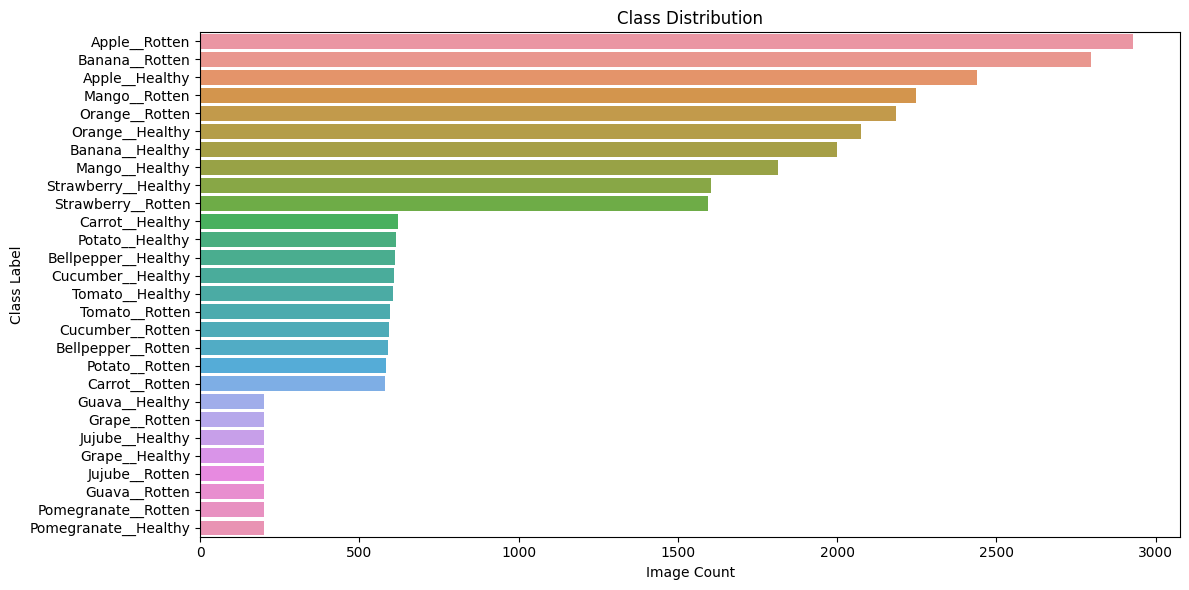

Phase 2 completed.


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

DATASET_PATH = Path("/kaggle/working/cleaned_dataset/")

def get_image_dataframe(dataset_path: Path) -> pd.DataFrame:
    data = []
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                full_path = os.path.join(root, file)
                label = os.path.basename(root)
                data.append((full_path, label))
    df = pd.DataFrame(data, columns=["filepath", "label"])
    if df.empty:
        raise RuntimeError(f"No images found under {dataset_path}. Did Phase 0 run?")
    print(f"Total images: {len(df)}")
    print(f"Total classes: {df['label'].nunique()}")
    return df

def plot_class_distribution(df: pd.DataFrame):
    plt.figure(figsize=(12, 6))
    sns.countplot(y='label', data=df, order=df['label'].value_counts().index)
    plt.title("Class Distribution")
    plt.xlabel("Image Count")
    plt.ylabel("Class Label")
    plt.tight_layout()
    plt.show()
    plt.close()

# Run Phase 2
print("Phase 2: Starting EDA...")
df_images = get_image_dataframe(DATASET_PATH)
print("\nPer-class counts:")
print(df_images['label'].value_counts().sort_index())

plot_class_distribution(df_images)
print("Phase 2 completed.")



# Phase 3 - Cross-Validation Splits (Enhanced from original)

In [4]:
from sklearn.model_selection import train_test_split, StratifiedKFold

# Paths
OUTPUT_SPLIT_DIR = Path("/kaggle/working/splits/")
OUTPUT_SPLIT_DIR.mkdir(parents=True, exist_ok=True)

# Split configuration from hyperparams
TEST_SIZE = hyperparams['test_split']
CV_FOLDS = hyperparams['cv_folds']
SEED = 42

def get_image_class_dataframe(dataset_path: Path) -> pd.DataFrame:
    data = []
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                full_path = os.path.join(root, file)
                label = os.path.basename(root)
                data.append((full_path, label))
    df = pd.DataFrame(data, columns=["filepath", "label"])
    if df.empty:
        raise RuntimeError(f"No images found under {dataset_path}. Did Phase 0 run?")
    # Stable order for reproducible splits
    df = df.sort_values("filepath").reset_index(drop=True)
    print(f"Found {len(df)} images in {df['label'].nunique()} classes")
    return df

def create_cv_splits_with_test(df: pd.DataFrame) -> Dict[str, Any]:
    """
    Create: 1) Final test set (20%), 2) Cross-validation splits on remaining 80%
    """
    # Validate for stratification
    class_counts = df['label'].value_counts()
    min_samples = class_counts.min()
    
    if min_samples < CV_FOLDS + 1:
        raise ValueError(f"Insufficient samples for {CV_FOLDS}-fold CV. "
                        f"Minimum class has {min_samples} samples, need at least {CV_FOLDS + 1}")
    
    print(f"Creating {CV_FOLDS}-fold CV with {TEST_SIZE:.0%} test holdout...")
    
    # First split: separate test set
    df_train_val, df_test = train_test_split(
        df,
        test_size=TEST_SIZE,
        stratify=df['label'],
        random_state=SEED,
        shuffle=True
    )
    
    print(f"Final test set: {len(df_test)} images ({len(df_test)/len(df):.1%})")
    print(f"Train+Val set: {len(df_train_val)} images ({len(df_train_val)/len(df):.1%})")
    
    # Create K-fold splits on train_val data
    skf = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=SEED)
    cv_splits = []
    
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(df_train_val, df_train_val['label'])):
        train_data = df_train_val.iloc[train_idx].reset_index(drop=True)
        val_data = df_train_val.iloc[val_idx].reset_index(drop=True)
        
        cv_splits.append({
            'fold': fold_idx,
            'train': train_data,
            'val': val_data
        })
        
        print(f"Fold {fold_idx + 1}: Train={len(train_data)}, Val={len(val_data)}")
    
    return {
        'test_set': df_test.reset_index(drop=True),
        'cv_splits': cv_splits,
        'metadata': {
            'total_samples': len(df),
            'test_samples': len(df_test),
            'cv_samples': len(df_train_val),
            'num_folds': CV_FOLDS,
            'num_classes': df['label'].nunique(),
            'class_names': sorted(df['label'].unique())
        }
    }

# Run Phase 3
print("Phase 3: Starting cross-validation dataset split")
df_all = get_image_class_dataframe(DATASET_PATH)
splits_data = create_cv_splits_with_test(df_all)

# Save test set for final evaluation
test_csv_path = OUTPUT_SPLIT_DIR / "test_split.csv"
splits_data['test_set'].to_csv(test_csv_path, index=False)
print(f"Test set saved to: {test_csv_path}")

print("Phase 3 completed successfully.")



Phase 3: Starting cross-validation dataset split
Found 29284 images in 28 classes
Creating 5-fold CV with 20% test holdout...
Final test set: 5857 images (20.0%)
Train+Val set: 23427 images (80.0%)
Fold 1: Train=18741, Val=4686
Fold 2: Train=18741, Val=4686
Fold 3: Train=18742, Val=4685
Fold 4: Train=18742, Val=4685
Fold 5: Train=18742, Val=4685
Test set saved to: /kaggle/working/splits/test_split.csv
Phase 3 completed successfully.


# Phase 4 - tf.data pipeline (Cross-validation ready)

In [5]:
import json
import tensorflow as tf
from tensorflow.keras import layers

# Constants from hyperparams
BATCH_SIZE = hyperparams['batch_size']
IMAGE_SIZE = hyperparams['image_size'][:2]
AUTOTUNE = tf.data.AUTOTUNE

# Create stable class mapping from all data
def build_class_mapping(class_names):
    """Build stable class mapping with TensorFlow lookup table"""
    class_to_idx = {name: idx for idx, name in enumerate(sorted(class_names))}
    idx_to_class = [name for name, _ in sorted(class_to_idx.items(), key=lambda x: x[1])]
    
    # Create TensorFlow lookup table
    keys_tensor = tf.constant(list(class_to_idx.keys()))
    vals_tensor = tf.constant(list(class_to_idx.values()), dtype=tf.int64)
    table_init = tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor)
    lookup_table = tf.lookup.StaticHashTable(table_init, default_value=-1)
    
    return {
        'class_to_idx': class_to_idx,
        'idx_to_class': idx_to_class,
        'lookup_table': lookup_table,
        'num_classes': len(class_names)
    }

# Build class mapping
class_mapping = build_class_mapping(splits_data['metadata']['class_names'])
NUM_CLASSES = class_mapping['num_classes']

@tf.function
def decode_image(filename: tf.Tensor, label_str: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
    img_raw = tf.io.read_file(filename)
    
    # Decode based on extension
    def decode_jpeg():
        return tf.image.decode_jpeg(img_raw, channels=3)
    
    def decode_png():
        return tf.image.decode_png(img_raw, channels=3)
    
    # Get extension
    ext = tf.strings.lower(tf.strings.split(filename, '.')[-1])
    img = tf.cond(
        tf.logical_or(tf.equal(ext, 'jpg'), tf.equal(ext, 'jpeg')),
        decode_jpeg,
        decode_png
    )
    
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, IMAGE_SIZE, method=tf.image.ResizeMethod.BILINEAR)
    img = tf.clip_by_value(img, 0, 255)
    img = tf.cast(img, tf.float32) / 255.0  # [0,1]

    label_id = class_mapping['lookup_table'].lookup(label_str)
    label_id = tf.where(label_id < 0, tf.zeros_like(label_id), label_id)
    one_hot = tf.one_hot(label_id, depth=NUM_CLASSES)
    return img, one_hot

@tf.function
def augment_image_hybrid(image: tf.Tensor, label: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
    """Enhanced augmentation for hybrid CNN+ViT model"""
    # Standard augmentations
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, 0.9, 1.1)
    
    # Additional augmentations for hybrid model
    image = tf.image.random_saturation(image, 0.9, 1.1)
    image = tf.image.random_hue(image, max_delta=0.05)
    
    # Random crop and resize (beneficial for patch-based ViT)
    if tf.random.uniform([]) > 0.3:
        crop_size = tf.random.uniform([], 0.85, 1.0)
        h = tf.cast(tf.cast(IMAGE_SIZE[0], tf.float32) * crop_size, tf.int32)
        w = tf.cast(tf.cast(IMAGE_SIZE[1], tf.float32) * crop_size, tf.int32)
        image = tf.image.random_crop(image, [h, w, 3])
        image = tf.image.resize(image, IMAGE_SIZE)
    
    return image, label

def build_dataset(df: pd.DataFrame, is_training: bool = True) -> tf.data.Dataset:
    """Build tf.data.Dataset from DataFrame"""
    filepaths = df['filepath'].values
    labels = df['label'].values
    
    ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    
    if is_training:
        ds = ds.shuffle(hyperparams['shuffle_buffer_size'], reshuffle_each_iteration=True)
    
    ds = ds.map(decode_image, num_parallel_calls=AUTOTUNE)
    
    if is_training:
        ds = ds.map(augment_image_hybrid, num_parallel_calls=AUTOTUNE)
    
    ds = ds.batch(BATCH_SIZE, drop_remainder=False)
    ds = ds.apply(tf.data.experimental.ignore_errors())
    ds = ds.prefetch(AUTOTUNE)
    return ds

def get_class_names():
    return class_mapping['idx_to_class']

print("Phase 4: tf.data pipeline ready for cross-validation")
print(f"Number of classes: {NUM_CLASSES}")
print("Phase 4 completed.")


Phase 4: tf.data pipeline ready for cross-validation
Number of classes: 28
Phase 4 completed.


I0000 00:00:1756197092.647259      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756197092.647958      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# Phase 5 - MobileNet+ViT Hybrid Model Builder

In [6]:
# Import necessary libruries
from tensorflow.keras import layers, models
from tensorflow.keras.utils import register_keras_serializable

# Enable mixed precision if configured
if hyperparams.get('use_mixed_precision', True):                   # Check if mixed precision is enabled in hyperparameters
    tf.keras.mixed_precision.set_global_policy('mixed_float16')    # Use 16-bit floats to speed up training
    print("Mixed precision enabled (float16) for hybrid model.")

# Custom ViT layers (with proper serialization for model saving/loading)
@register_keras_serializable(package="custom")                      # Makes this layer serializable for model saving
class PatchEmbedding(layers.Layer):
    """
    Conv2D patchify + linear projection → (B, N, D)
    """
    def __init__(self, embed_dim=64, patch_size=16, **kwargs):
        super().__init__(**kwargs)                              # Initialize parent Layer class
        self.embed_dim = embed_dim                              # Dimension of embedding vector for each patch
        self.patch_size = patch_size                            # Size of each square patch (16x16 pixels)
        self.proj = layers.Conv2D(
            self.embed_dim,                          # Output channels = embedding dimension
            kernel_size=self.patch_size,             # Filter size matches patch size
            strides=self.patch_size,                 # Move by patch_size to avoid overlap
            padding="valid",                         # No padding needed
            name="patch_conv"
        )
        self.reshape = layers.Reshape((-1, self.embed_dim))

    def call(self, x):
        """Forward pass through the layer"""
        x = self.proj(x)                           # Extract patches and project to embedding dimension
        x = self.reshape(x)                        # Flatten spatial dimensions into sequence of patches
        return x

    def get_config(self):
        """Required for layer serialization - saves layer parameters"""
        config = super().get_config()              # Get parent class config
        config.update({                            # Add our custom parameters
            "embed_dim": self.embed_dim,
            "patch_size": self.patch_size
        })
        return config

@register_keras_serializable(package="custom")               # Make this layer serializable too
class AddClassPosEmbed(layers.Layer):
    """Add learnable [CLS] token and positional embedding"""
    def __init__(self, embed_dim=64, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim                           # Must match patch embedding dimension

    def build(self, input_shape):
        _, n_tokens, d = input_shape                         # Get number of patches and embedding dimension
        self.cls_token = self.add_weight(
            name="cls_token",
            shape=(1, 1, d),                         # 1 token with embedding dimension d
            initializer="zeros",                     # Start with zeros
            trainable=True                           # This will be learned during training
        )
        # Positional embeddings
        self.pos_embed = self.add_weight(
            name="pos_embed",
            shape=(1, n_tokens + 1, d),               # +1 for CLS token
            initializer="random_normal",              # Start with random values
            trainable=True                            # Learn during training
        )

    def call(self, x):
        batch_size = tf.shape(x)[0]                   # Get current batch size 
        cls_tokens = tf.tile(self.cls_token, [batch_size, 1, 1]) # Replicate CLS token for each sample in the batch
        x = tf.concat([cls_tokens, x], axis=1)        # Concatenate CLS token at the beginning of sequence
        x = x + self.pos_embed                        # Add positional embeddings to all tokens
        return x

    def get_config(self):
        config = super().get_config()
        config.update({"embed_dim": self.embed_dim})
        return config

def transformer_encoder_block(
    embed_dim: int,             # Embedding dimension (must be consistent)
    num_heads: int,             # Number of attention heads in multi-head attention
    mlp_dim: int,               # Hidden dimension in feed-forward network
    dropout_rate: float = 0.1,  # Dropout probability for regularization
    name: str = "transformer"   # Base name for all layers in this block
) -> tf.keras.Model:
    """
    Transformer encoder block: LayerNorm → MultiHeadAttention → Add → LayerNorm → MLP → Add
    """
    inputs = layers.Input(shape=(None, embed_dim))     # Input placeholder
    
    # Multi-head self-attention
    x = layers.LayerNormalization(epsilon=1e-6, name=f"{name}_ln1")(inputs)
    attn_output = layers.MultiHeadAttention(
        num_heads=num_heads,     # Split embedding into multiple heads
        key_dim=embed_dim,       # Dimension of each attention head
        dropout=dropout_rate,    # Dropout in attention weights
        name=f"{name}_mha"
    )(x, x)                      # Self-attention
    x = layers.Add(name=f"{name}_add1")([inputs, attn_output])
    
    # MLP block
    y = layers.LayerNormalization(epsilon=1e-6, name=f"{name}_ln2")(x)
    y = layers.Dense(mlp_dim, activation="gelu", name=f"{name}_mlp1")(y)
    y = layers.Dropout(dropout_rate, name=f"{name}_dropout1")(y)     # Regularization 
    y = layers.Dense(embed_dim, name=f"{name}_mlp2")(y)              # Project back to embed_dim
    y = layers.Dropout(dropout_rate, name=f"{name}_dropout2")(y)
    
    outputs = layers.Add(name=f"{name}_add2")([x, y])
    
    return models.Model(inputs, outputs, name=name)

def create_hybrid_mobilenet_vit(
    input_shape=(224, 224, 3),         # Input image dimensions
    num_classes: int = 28,             # Number of output classes
    patch_size: int = 16,              # ViT patch size
    vit_embed_dim: int = 64,           # ViT embedding dimension
    vit_depth: int = 6,                # Number of transformer blocks
    vit_heads: int = 4,                # Number of attention heads
    vit_mlp_dim: int = 128,            # MLP hidden dimension in transformer
    fusion_dim: int = 256,             # Dimension for feature fusion layers
    dropout_rate: float = 0.2,         # Dropout rate throughout model
    cnn_trainable_initial: bool = False  # Whether CNN starts trainable
) -> tf.keras.Model:
    """
    Hybrid MobileNetV2 + Vision Transformer model with feature fusion
    
    Architecture:
    - CNN Branch: MobileNetV2 backbone for local feature extraction
    - ViT Branch: Patch embedding + transformer blocks for global context
    - Fusion: Concatenate CNN and ViT features → Dense layers → Classification
    """
    inputs = layers.Input(shape=input_shape, name="input_image")
    
    # CNN Branch (MobileNetV2) 
    # MobileNetV2 expects inputs in [-1, 1]
    cnn_input = layers.Rescaling(scale=2.0, offset=-1.0, name="cnn_rescale")(inputs)
    
    # Load MobileNetV2 backbone
    mobilenet_backbone = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,   # Must match our input
        include_top=False,         # Don't include final classification layers
        weights="imagenet",        # Use ImageNet pretrained weights
        alpha=1.0                  # Width multiplier 
    )
    mobilenet_backbone.trainable = cnn_trainable_initial
    mobilenet_backbone._name = "mobilenetv2_backbone"
    
    # Extract CNN features
    cnn_features = mobilenet_backbone(cnn_input)
    cnn_features = layers.GlobalAveragePooling2D(name="cnn_gap")(cnn_features)
    cnn_features = layers.BatchNormalization(name="cnn_bn")(cnn_features)
    cnn_features = layers.Dropout(dropout_rate, name="cnn_dropout")(cnn_features)
    
    # ViT Branch 
    # ViT operates on [0, 1] inputs
    vit_input = layers.Lambda(lambda x: x, name="vit_input")(inputs)
    
    # Patch embedding
    vit_patches = PatchEmbedding(
        embed_dim=vit_embed_dim,    # Each patch becomes this dimension vector
        patch_size=patch_size,      # Size of each patch
        name="vit_patch_embed"
    )(vit_input)
    
    # Add CLS token and positional embedding
    vit_embedded = AddClassPosEmbed(
        embed_dim=vit_embed_dim,
        name="vit_cls_pos"
    )(vit_patches)
    
    # Transformer encoder blocks
    vit_features = vit_embedded
    for i in range(vit_depth):
        transformer_block = transformer_encoder_block(
            embed_dim=vit_embed_dim,
            num_heads=vit_heads,
            mlp_dim=vit_mlp_dim,
            dropout_rate=dropout_rate,
            name=f"vit_transformer_block_{i+1}"
        )
        vit_features = transformer_block(vit_features)
    
    # Extract CLS token (global representation)
    vit_cls_token = layers.Lambda(
        lambda x: x[:, 0],
        name="vit_extract_cls"
    )(vit_features)
    
    vit_cls_token = layers.BatchNormalization(name="vit_bn")(vit_cls_token)
    vit_cls_token = layers.Dropout(dropout_rate, name="vit_dropout")(vit_cls_token)
    
    # Feature Fusion 
    # Concatenate CNN and ViT features
    fused_features = layers.Concatenate(name="feature_fusion")([cnn_features, vit_cls_token])
    
    # Fusion head
    x = layers.Dense(fusion_dim, activation="gelu", name="fusion_dense1")(fused_features)
    x = layers.BatchNormalization(name="fusion_bn1")(x)           # Normalize activations
    x = layers.Dropout(dropout_rate, name="fusion_dropout1")(x)   # Prevent overfitting
    
    x = layers.Dense(fusion_dim // 2, activation="gelu", name="fusion_dense2")(x)
    x = layers.BatchNormalization(name="fusion_bn2")(x)
    x = layers.Dropout(dropout_rate, name="fusion_dropout2")(x)
    
    # Final classification layer (float32 for numerical stability)
    outputs = layers.Dense(
        num_classes,           # Number of output classes
        activation="softmax",  # Softmax for multi-class classification
        dtype="float32",       # Force float32 for numerical stability
        name="predictions"
    )(x)
    
    model = models.Model(inputs, outputs, name="Hybrid_MobileNetV2_ViT")
    return model

# Build hybrid model with hyperparameters
print("Building MobileNet+ViT Hybrid Model...")
hybrid_model = create_hybrid_mobilenet_vit(
    input_shape=hyperparams['image_size'],      # From hyperparameter dict
    num_classes=NUM_CLASSES,                    # Number of classes in dataset
    patch_size=hyperparams['vit_patch_size'],   # ViT patch size
    vit_embed_dim=hyperparams['vit_embed_dim'], # ViT embedding dimension
    vit_depth=hyperparams['vit_depth'],         # Number of transformer blocks
    vit_heads=hyperparams['vit_heads'],         # Attention heads per block
    vit_mlp_dim=hyperparams['vit_mlp_dim'],     # MLP dimension in transformer
    fusion_dim=hyperparams['fusion_dim'],       # Fusion layer dimension
    dropout_rate=hyperparams['dropout_rate'],   # Dropout rate for regularization
    cnn_trainable_initial=False                 # Start with CNN frozen (transfer learning)
)

print("Phase 5: MobileNet+ViT Hybrid model builder ready")
print(f"Model input shape: {hyperparams['image_size']}")
print(f"Number of classes: {NUM_CLASSES}")
print(f"ViT patch size: {hyperparams['vit_patch_size']}")
print(f"ViT embedding dimension: {hyperparams['vit_embed_dim']}")
print(f"ViT transformer depth: {hyperparams['vit_depth']}")
print("Phase 5 completed.")


Mixed precision enabled (float16) for hybrid model.
Building MobileNet+ViT Hybrid Model...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Phase 5: MobileNet+ViT Hybrid model builder ready
Model input shape: (224, 224, 3)
Number of classes: 28
ViT patch size: 16
ViT embedding dimension: 64
ViT transformer depth: 6
Phase 5 completed.


# Phase 6 - Cross-Validation Training (MobileNet+ViT Hybrid)

In [7]:
# Import necessary libraries
from tensorflow.keras import callbacks
from tensorflow.keras.losses import CategoricalCrossentropy

# Pull hyperparams
EPOCHS1 = hyperparams['epochs_stage1']                    # Number of training epochs for stage 1 (ViT training)
EPOCHS2 = hyperparams['epochs_stage2']                    # Number of training epochs for stage 2 (fine-tuning)
LR1 = hyperparams['learning_rate_stage1']                 # Learning rate for stage 1 (typically higher)
LR2 = hyperparams['learning_rate_stage2']                 # Learning rate for stage 2 (typically lower for fine-tuning)
DROPOUT = hyperparams['dropout_rate']                     # Dropout rate for regularization to prevent overfitting
CNN_UNFREEZE_LAYERS = hyperparams['cnn_unfreeze_layers']  # How many CNN layers to unfreeze in stage 2

# Output paths
CKPT_DIR = Path("/kaggle/working/checkpoints/")      # Directory for saving model checkpoints during training
LOG_DIR = Path("/kaggle/working/logs/")              # Directory for saving training logs
MODEL_DIR = Path("/kaggle/working/models/")          # Directory for saving final trained models
for p in (CKPT_DIR, LOG_DIR, MODEL_DIR):             # Create all directories if they don't exist
    p.mkdir(parents=True, exist_ok=True)

def make_callbacks(fold_idx: int, stage: str):
    """Create callbacks for hybrid model training"""
    fold_ckpt_dir = CKPT_DIR / f"fold_{fold_idx}"
    fold_ckpt_dir.mkdir(parents=True, exist_ok=True)
    
    return [
        # Early Stopping
        callbacks.EarlyStopping(
            monitor="val_accuracy",                           # Metric to monitor for improvement
            patience=hyperparams['early_stopping_patience'],  # Number of epochs to wait before stopping
            mode="max",                                       # We want to maximize accuracy 
            restore_best_weights=True,                        # Restore the best weights when stopping
            verbose=1                                         # Print messages when stopping
        ),
        
        # Reduce Learning Rate on Plateau: Reduces LR when validation accuracy plateaus
        callbacks.ReduceLROnPlateau(
            monitor="val_accuracy",                           # Metric to monitor
            factor=0.5,                                       # Factor by which to reduce the learning rate 
            patience=hyperparams['reduce_lr_patience'],       # Number of epochs with no improvement after which LR is reduced
            mode="max",                                       # We want to maximize accuracy
            verbose=1,                                        # Print messages when reducing LR
            min_lr=1e-7                                       # Minimum learning rate 
        ),
        
        # Model Checkpoint: Saves the best model during training
        callbacks.ModelCheckpoint(
            str(fold_ckpt_dir / f"best_hybrid_{stage}.h5"),  # Path where to save the model
            monitor="val_accuracy",                          # Metric to monitor for "best" model
            save_best_only=True,                             # Only save when the monitored metric improves
            save_weights_only=False,                         # Save the entire model, not just weights
            mode="max",                                      # We want to maximize accuracy
            verbose=1                                        # Print messages when saving
        )
    ]

def unfreeze_mobilenet_layers(model, num_layers_to_unfreeze):
    """
    Unfreeze the last N layers of MobileNetV2 backbone in the hybrid model
    """
    mobilenet_backbone = None
    
    for layer in model.layers:                                   # Find MobileNetV2 backbone
        if hasattr(layer, 'name') and 'mobilenetv2' in layer.name.lower():
            mobilenet_backbone = layer
            break
    
    if mobilenet_backbone is None:
        print("Warning: MobileNetV2 backbone not found. Skipping CNN unfreezing.")
        return
    
    for layer in mobilenet_backbone.layers:                      # Freeze all layers first
        layer.trainable = False
    
    layers_to_unfreeze = min(num_layers_to_unfreeze, len(mobilenet_backbone.layers))   # Unfreeze last N layers
    for layer in mobilenet_backbone.layers[-layers_to_unfreeze:]:
        layer.trainable = True
        # Keep BatchNormalization layers frozen for stability
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False
    
    print(f"Unfroze last {layers_to_unfreeze} layers of MobileNetV2 (BatchNorm kept frozen)")

def train_single_fold_hybrid(fold_data, fold_idx):
    """Train a single fold with two-stage hybrid approach"""
    print(f"\n{'='*70}")
    print(f"Training Hybrid Model - Fold {fold_idx + 1}/{len(splits_data['cv_splits'])}")
    print(f"{'='*70}")
    
    # Create datasets
    train_ds = build_dataset(fold_data['train'], is_training=True)
    val_ds = build_dataset(fold_data['val'], is_training=False)
    
    # Create fresh hybrid model for this fold
    model = create_hybrid_mobilenet_vit(
        input_shape=hyperparams['image_size'],     # Input image dimensions (e.g., (224, 224, 3))
        num_classes=NUM_CLASSES,                   # Number of output classes for classification
        patch_size=hyperparams['vit_patch_size'],  # Size of patches for Vision Transformer (e.g., 16x16)
        vit_embed_dim=hyperparams['vit_embed_dim'],  # Embedding dimension for ViT
        vit_depth=hyperparams['vit_depth'],        # Number of transformer layers in ViT
        vit_heads=hyperparams['vit_heads'],        # Number of attention heads in ViT
        vit_mlp_dim=hyperparams['vit_mlp_dim'],    # MLP dimension in ViT transformer blocks
        fusion_dim=hyperparams['fusion_dim'],      # Dimension for fusing CNN and ViT features
        dropout_rate=DROPOUT,                      # Dropout rate for regularization
        cnn_trainable_initial=False 
    )
    
    # Stage 1: Train ViT + Fusion Head (CNN Frozen) 
    print("Stage 1: Training ViT + Fusion Head with frozen CNN backbone...")
    optimizer_1 = tf.keras.optimizers.Adam(learning_rate=LR1)
    model.compile(
        optimizer=optimizer_1,
        loss=CategoricalCrossentropy(label_smoothing=hyperparams['label_smoothing_stage1']),
        metrics=["accuracy"]
    )
    
    # Train the model for stage 1
    history_1 = model.fit(
        train_ds,                                    # Training dataset
        validation_data=val_ds,                      # Validation dataset for monitoring
        epochs=EPOCHS1,                              # Number of epochs for stage 1
        callbacks=make_callbacks(fold_idx, "stage1"), # Callbacks for this stage
        verbose=1                                     # Print training progress
    )
    
    # Stage 2: Fine-tune Entire Hybrid Model 
    print("Stage 2: Fine-tuning entire hybrid model...")
    
    # Unfreeze CNN layers
    unfreeze_mobilenet_layers(model, CNN_UNFREEZE_LAYERS)
    
    # Compile with lower learning rate
    optimizer_2 = tf.keras.optimizers.Adam(learning_rate=LR2)
    model.compile(
        optimizer=optimizer_2,
        loss=CategoricalCrossentropy(label_smoothing=hyperparams['label_smoothing_stage2']),
        metrics=["accuracy"]
    )
    
    # Train the model for stage 2 (fine-tuning)
    history_2 = model.fit(
        train_ds,                                      # Same training dataset
        validation_data=val_ds,                        # Same validation dataset
        epochs=EPOCHS2,                                # Number of epochs for stage 2 
        callbacks=make_callbacks(fold_idx, "stage2"),  # Callbacks for this stage
        verbose=1                                      # Print training progress
    )
    
    # Evaluate final model
    val_metrics = model.evaluate(val_ds, verbose=0)  # verbose=0 for quiet evaluation
    val_accuracy = val_metrics[1]                    # Accuracy is the second metric (index 1)
    val_loss = val_metrics[0]                        # Loss is the first metric (index 0)
    
    # Print final results for this fold
    print(f"Fold {fold_idx + 1} Final Validation Accuracy: {val_accuracy:.4f}")
    print(f"Fold {fold_idx + 1} Final Validation Loss: {val_loss:.4f}")
    
    # Return all important information about this fold's training
    return {
        'fold': fold_idx,                 # Fold index for identification
        'val_accuracy': val_accuracy,     # Final validation accuracy
        'val_loss': val_loss,             # Final validation loss
        'model': model,                   # Trained model (for potential ensemble use)
        'history': {                      # Training histories from both stages
            'stage1': history_1.history,  # Stage 1 training history
            'stage2': history_2.history   # Stage 2 training history
        }
    }

# Run cross-validation training
print("Starting Cross-Validation Training for Hybrid Model...")
cv_results = []
all_models = []

# Loop through each fold in the cross-validation splits
for fold_idx, fold_data in enumerate(splits_data['cv_splits']):
    fold_result = train_single_fold_hybrid(fold_data, fold_idx)
    cv_results.append(fold_result)
    all_models.append(fold_result['model'])
    
    # Clean up memory after each fold
    tf.keras.backend.clear_session()

# Calculate CV statistics
fold_accuracies = [result['val_accuracy'] for result in cv_results]
fold_losses = [result['val_loss'] for result in cv_results]
cv_mean = np.mean(fold_accuracies)
cv_std = np.std(fold_accuracies)
loss_mean = np.mean(fold_losses)
loss_std = np.std(fold_losses)

print(f"\n{'='*70}")
print(f"Hybrid Model Cross-Validation Results Summary")
print(f"{'='*70}")
print(f"Mean Accuracy: {cv_mean:.4f} ± {cv_std:.4f}")
print(f"Mean Loss: {loss_mean:.4f} ± {loss_std:.4f}")
print(f"Individual fold accuracies: {[f'{acc:.4f}' for acc in fold_accuracies]}")
print(f"Best fold accuracy: {max(fold_accuracies):.4f}")
print(f"Worst fold accuracy: {min(fold_accuracies):.4f}")
print(f"Accuracy range: {max(fold_accuracies) - min(fold_accuracies):.4f}")

print("Cross-Validation Training completed for Hybrid Model.")


Starting Cross-Validation Training for Hybrid Model...

Training Hybrid Model - Fold 1/5
Stage 1: Training ViT + Fusion Head with frozen CNN backbone...
Epoch 1/12


I0000 00:00:1756197147.625843     102 service.cc:148] XLA service 0x7facac0205c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756197147.626900     102 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1756197147.626919     102 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1756197151.822836     102 cuda_dnn.cc:529] Loaded cuDNN version 90300


      3/Unknown 65s 43ms/step - accuracy: 0.0463 - loss: 4.3153

I0000 00:00:1756197178.322790     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    780/Unknown 161s 123ms/step - accuracy: 0.6981 - loss: 1.6058

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_accuracy improved from -inf to 0.92979, saving model to /kaggle/working/checkpoints/fold_0/best_hybrid_stage1.h5
780/780 ━━━━━━━━━━━━━━━━━━━━ 182s 150ms/step - accuracy: 0.6983 - loss: 1.6054 - val_accuracy: 0.9298 - val_loss: 0.9313 - learning_rate: 0.0010
Epoch 2/12
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8998 - loss: 0.9964
Epoch 2: val_accuracy improved from 0.92979 to 0.95455, saving model to /kaggle/working/checkpoints/fold_0/best_hybrid_stage1.h5
780/780 ━━━━━━━━━━━━━━━━━━━━ 81s 104ms/step - accuracy: 0.8998 - loss: 0.9964 - val_accuracy: 0.9545 - val_loss: 0.8431 - learning_rate: 0.0010
Epoch 3/12
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9189 - loss: 0.9290
Epoch 3: val_accuracy improved from 0.95455 to 0.96265, saving model to /kaggle/working/checkpoints/fold_0/best_hybrid_stage1.h5
780/780 ━━━━━━━━━━━━━━━━━━━━ 79s 101ms/step - accuracy: 0.9189 - loss: 0.9290 - val_accuracy: 0.9627 - val_loss: 0.8161 - learning_rate: 0.0010
Epoch 4/

# Phase 7 - Final Model Selection and Test Evaluation

In [8]:
# Import necessary libraries
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support

# Select best model from CV
best_fold_idx = np.argmax(fold_accuracies)
best_model = cv_results[best_fold_idx]['model']
print(f"Selected best hybrid model from fold {best_fold_idx + 1}")
print(f"Best fold validation accuracy: {fold_accuracies[best_fold_idx]:.4f}")

# Save best model
final_model_path = MODEL_DIR / "best_hybrid_mobilenet_vit_final.h5"
best_model.save(final_model_path)
print(f"Best hybrid model saved to: {final_model_path}")

# Evaluate on test set
print(f"\n{'='*70}")
print(f"Final Test Set Evaluation - Hybrid MobileNet+ViT")
print(f"{'='*70}")

test_ds = build_dataset(splits_data['test_set'], is_training=False)

# Collect predictions
y_true_idx = []      # Ground truth class indices
y_pred_probs = []    # Predicted probabilities for each class

print("Collecting predictions on test set...")
for batch_imgs, batch_labels in test_ds:
    y_true_idx.extend(tf.argmax(batch_labels, axis=-1).numpy())
    preds = best_model.predict(batch_imgs, verbose=0)
    y_pred_probs.extend(preds)

y_true_idx = np.array(y_true_idx)
y_pred_probs = np.array(y_pred_probs)
y_pred_idx = np.argmax(y_pred_probs, axis=-1)

# Calculate metrics
test_accuracy = accuracy_score(y_true_idx, y_pred_idx)

# Top-k accuracies
def top_k_accuracy(y_true, y_prob, k):
    top_k_preds = np.argsort(-y_prob, axis=1)[:, :k]
    return np.mean([y_true[i] in top_k_preds[i] for i in range(len(y_true))])

top3_accuracy = top_k_accuracy(y_true_idx, y_pred_probs, 3)
top5_accuracy = top_k_accuracy(y_true_idx, y_pred_probs, 5)

# Classification report
class_names = get_class_names()
clf_report = classification_report(
    y_true_idx, y_pred_idx, 
    target_names=class_names, 
    output_dict=True, 
    zero_division=0
)

# Confusion matrix
conf_matrix = confusion_matrix(y_true_idx, y_pred_idx)

print(f"Test Accuracy (Top-1): {test_accuracy:.4f}")
print(f"Test Accuracy (Top-3): {top3_accuracy:.4f}")
print(f"Test Accuracy (Top-5): {top5_accuracy:.4f}")

# Calculate precision, recall, f1-score for each class
precision, recall, f1, support = precision_recall_fscore_support(
    y_true_idx, y_pred_idx, average=None, zero_division=0
)

# Calculate macro and weighted averages
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    y_true_idx, y_pred_idx, average='macro', zero_division=0
)
precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
    y_true_idx, y_pred_idx, average='weighted', zero_division=0
)

# Create comprehensive metrics table
RESULTS_DIR = Path("/kaggle/working/results/")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

metrics_table = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

# Add summary rows
summary_rows = pd.DataFrame({
    'Class': ['Macro Avg', 'Weighted Avg'],
    'Precision': [precision_macro, precision_weighted],
    'Recall': [recall_macro, recall_weighted],
    'F1-Score': [f1_macro, f1_weighted],
    'Support': [np.sum(support), np.sum(support)]
})

metrics_table = pd.concat([metrics_table, summary_rows], ignore_index=True)

# Display table
print(f"\nPrecision, Recall, F1-Score Table:")
print("=" * 70)
print(metrics_table.round(4).to_string(index=False))

# Save table
metrics_table.to_csv(RESULTS_DIR / "hybrid_precision_recall_f1_table.csv", index=False)
print(f"\nMetrics table saved to: {RESULTS_DIR / 'hybrid_precision_recall_f1_table.csv'}")

print("Phase 7 completed.")


Selected best hybrid model from fold 4
Best fold validation accuracy: 0.9848
Best hybrid model saved to: /kaggle/working/models/best_hybrid_mobilenet_vit_final.h5

Final Test Set Evaluation - Hybrid MobileNet+ViT
Test Accuracy (Top-1): 0.9855
Test Accuracy (Top-3): 0.9986
Test Accuracy (Top-5): 0.9995

Precision, Recall, F1-Score Table:
               Class  Precision  Recall  F1-Score  Support
      Apple__Healthy     0.9979  0.9979    0.9979      487
       Apple__Rotten     0.9948  0.9897    0.9922      580
     Banana__Healthy     0.9975  1.0000    0.9987      394
      Banana__Rotten     0.9982  0.9982    0.9982      554
 Bellpepper__Healthy     0.9756  1.0000    0.9877      120
  Bellpepper__Rotten     0.9464  0.9060    0.9258      117
     Carrot__Healthy     0.9590  0.9669    0.9630      121
      Carrot__Rotten     0.9478  0.9478    0.9478      115
   Cucumber__Healthy     0.9313  1.0000    0.9644      122
    Cucumber__Rotten     0.9561  0.9237    0.9397      118
      Grape_

# Phase 8 - Comprehensive Evaluation and Visualization

Creating comprehensive visualizations for Hybrid Model...


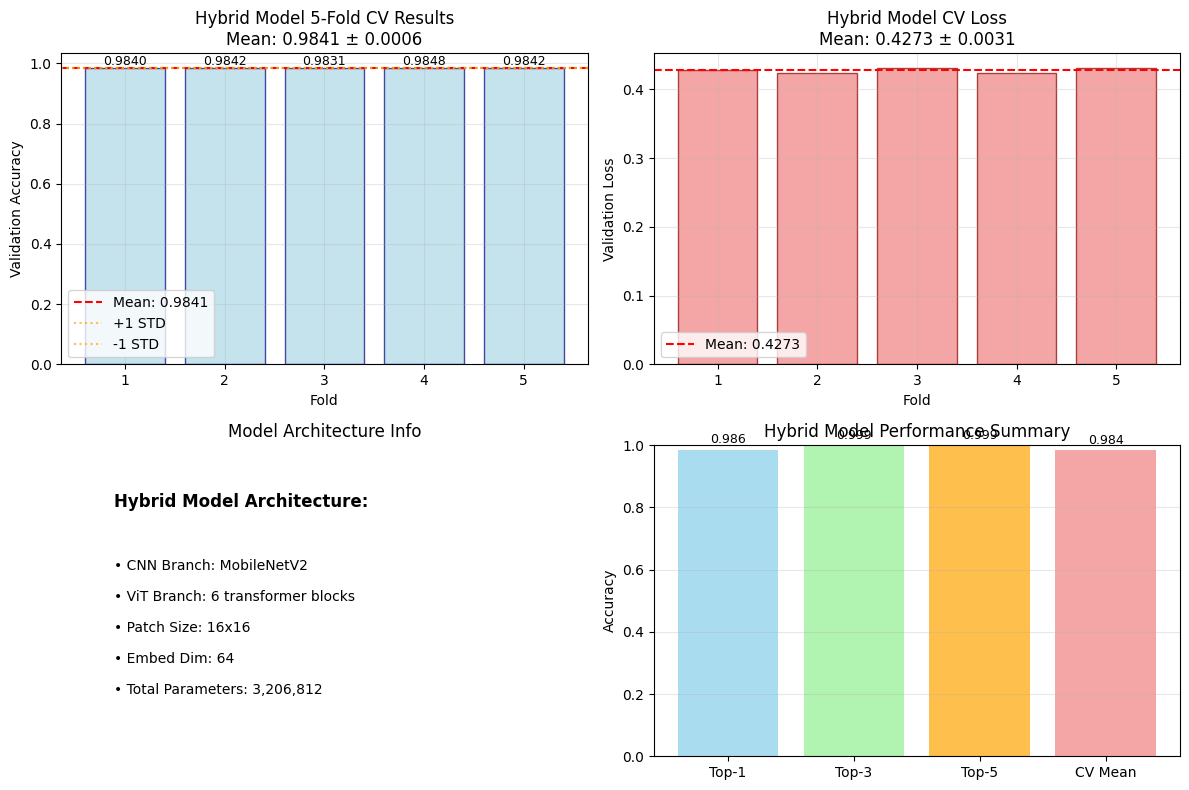

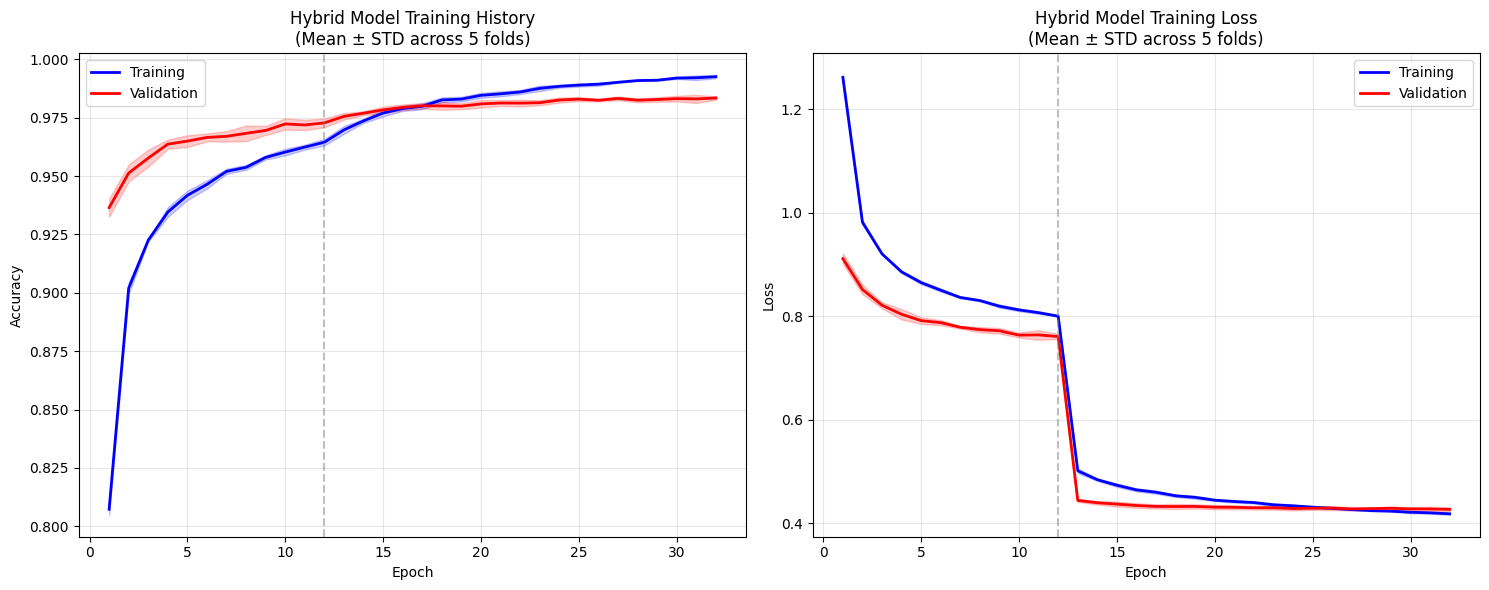

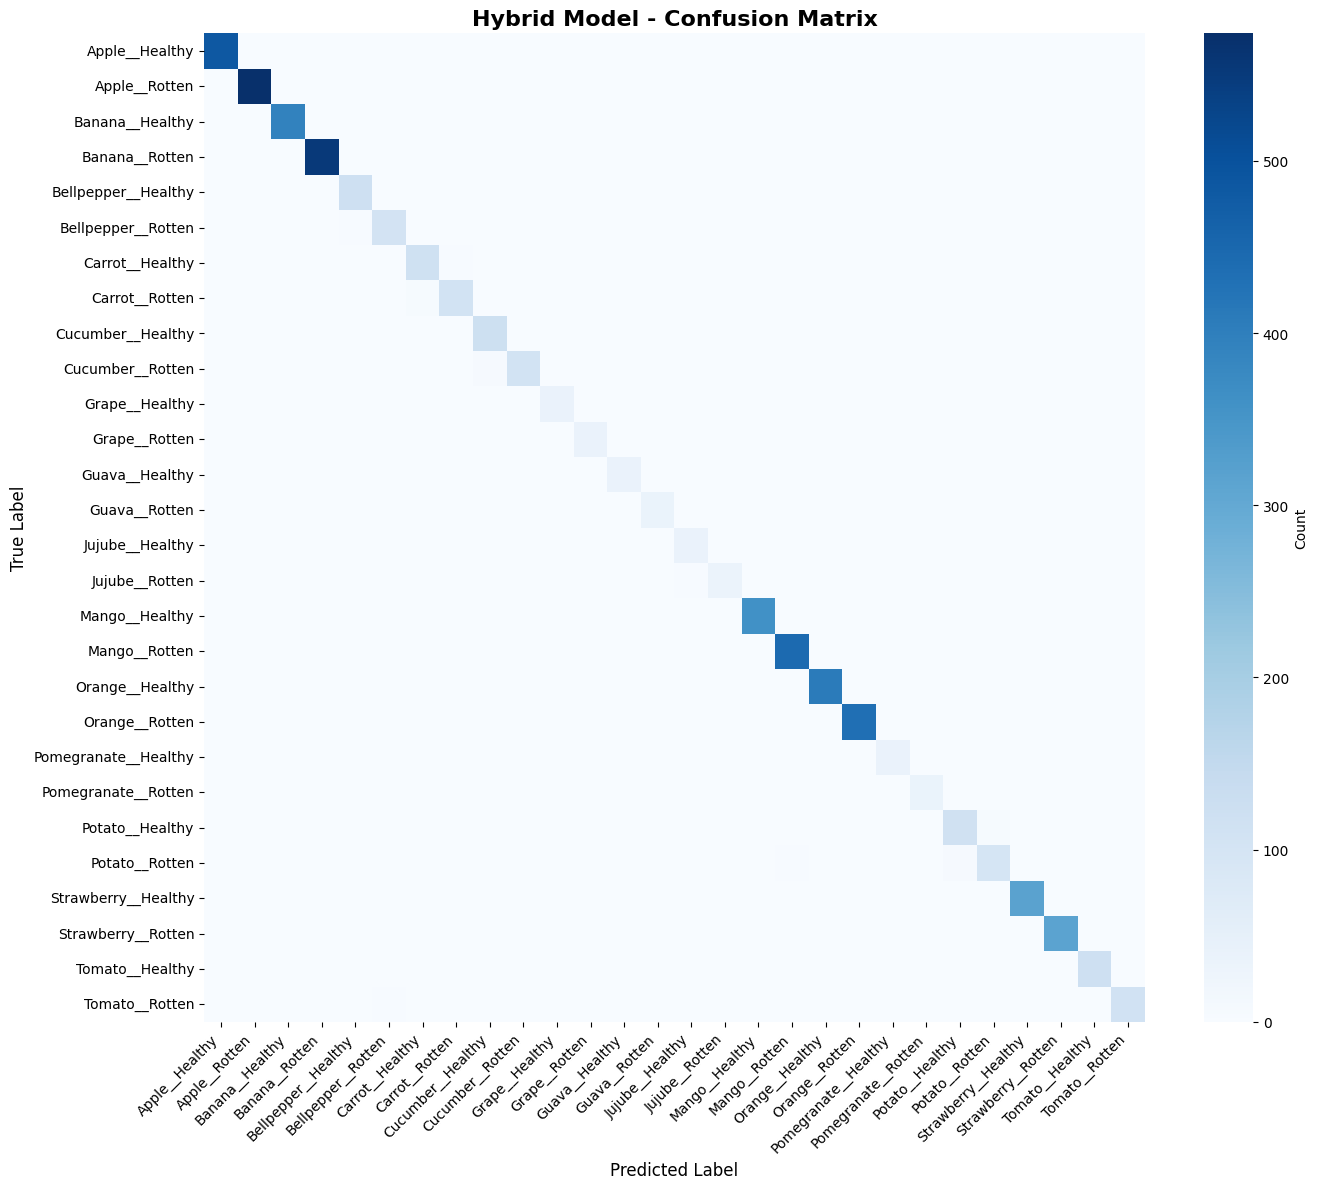

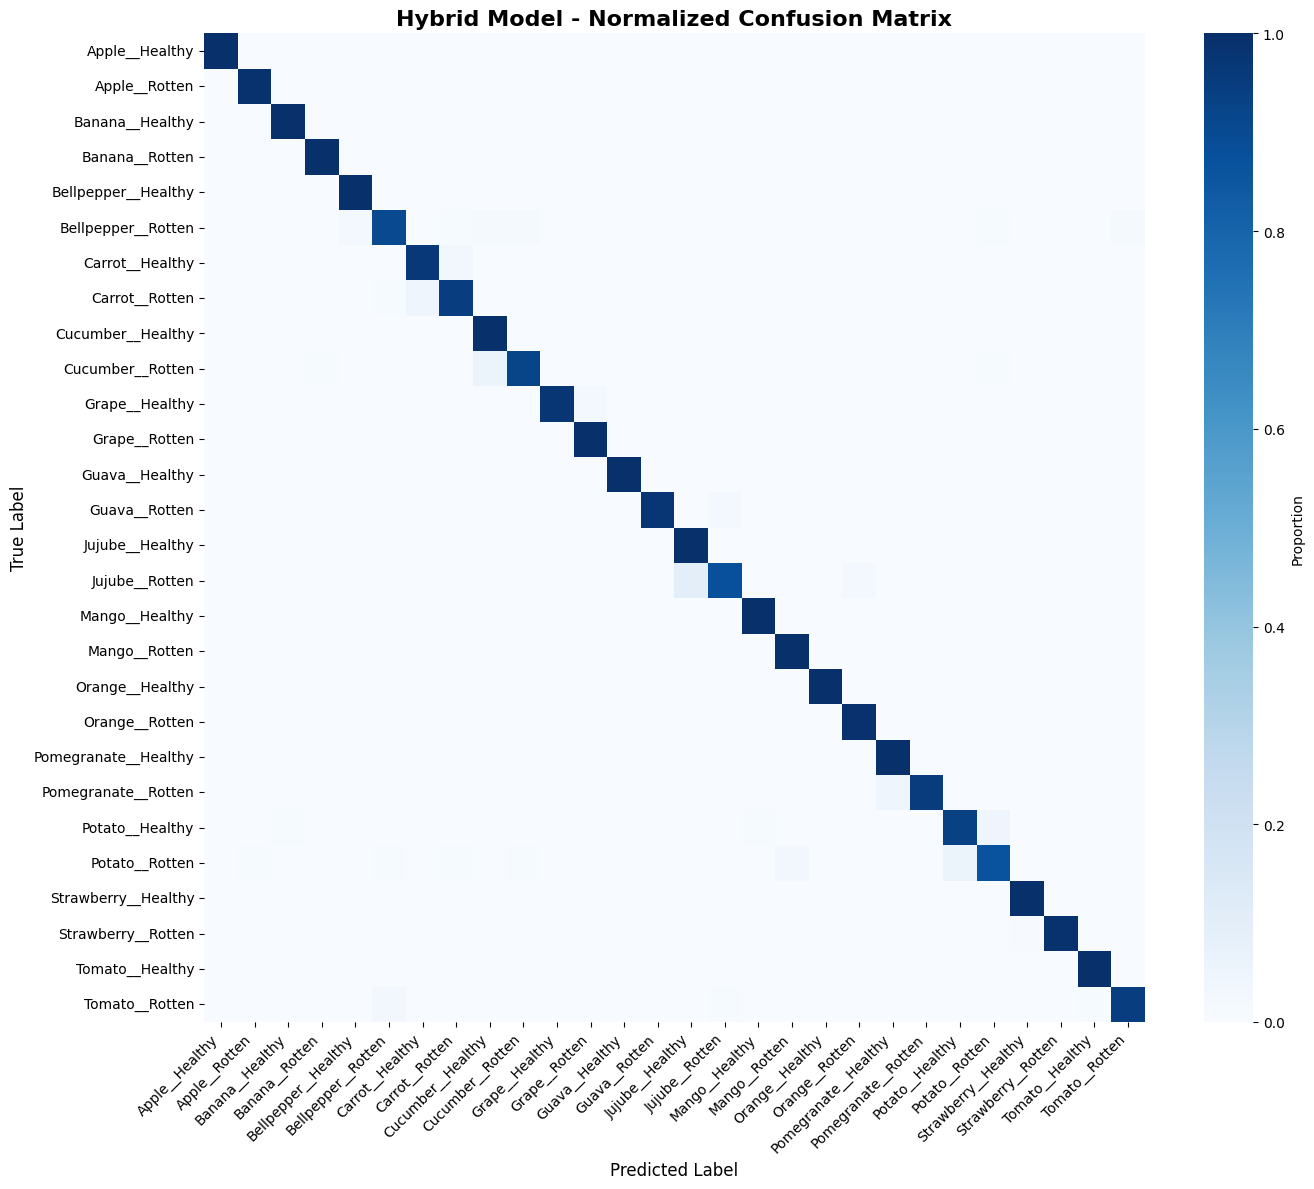

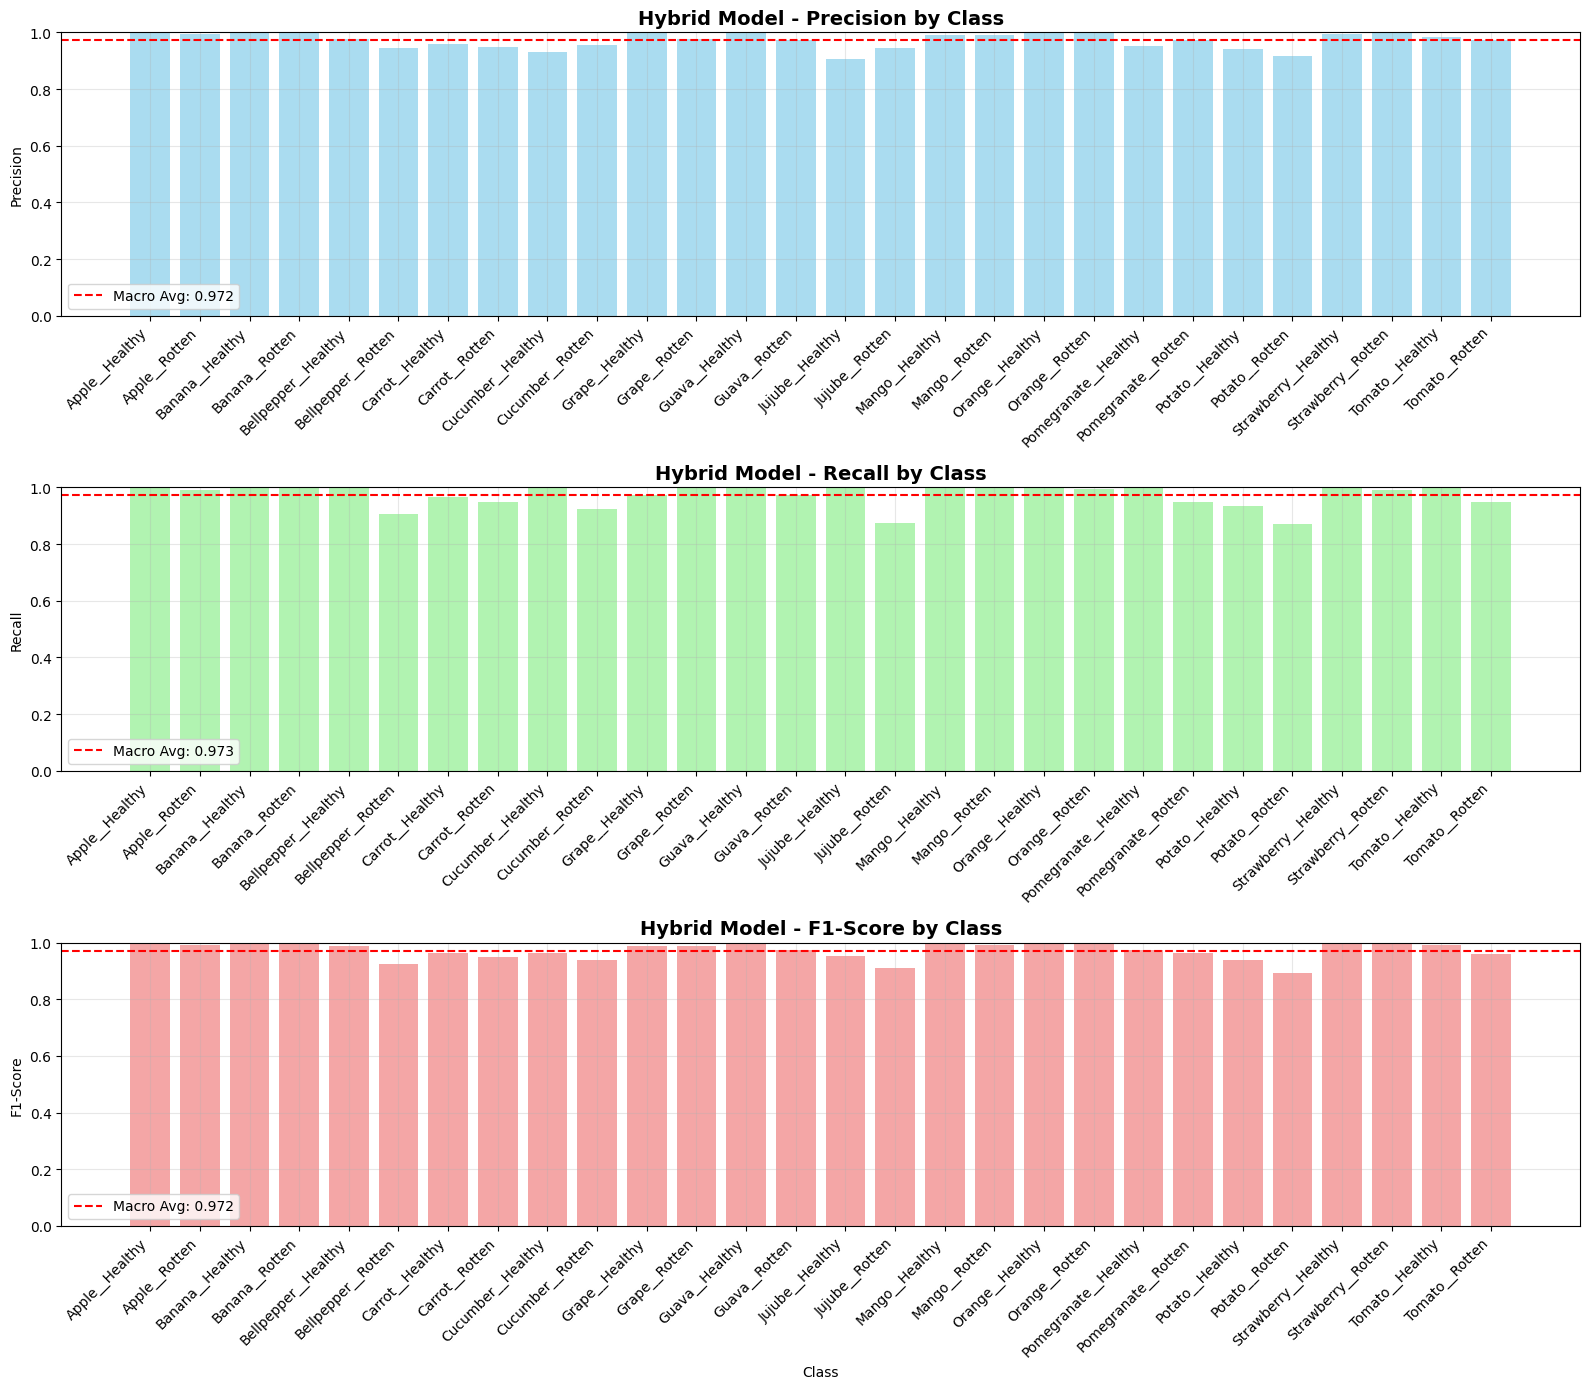

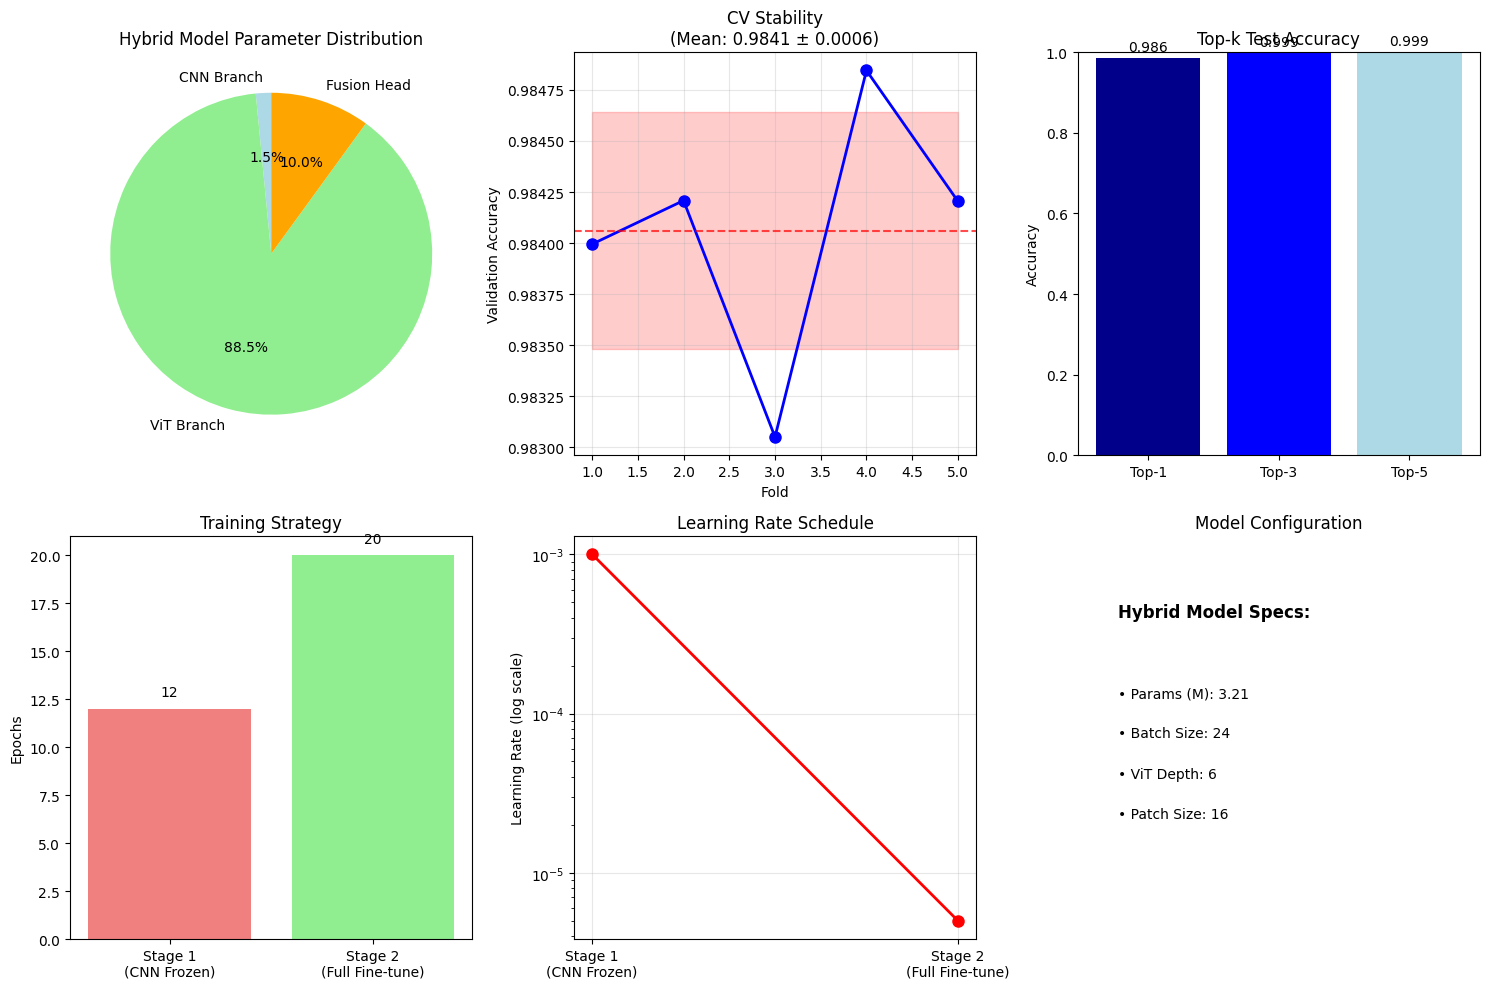

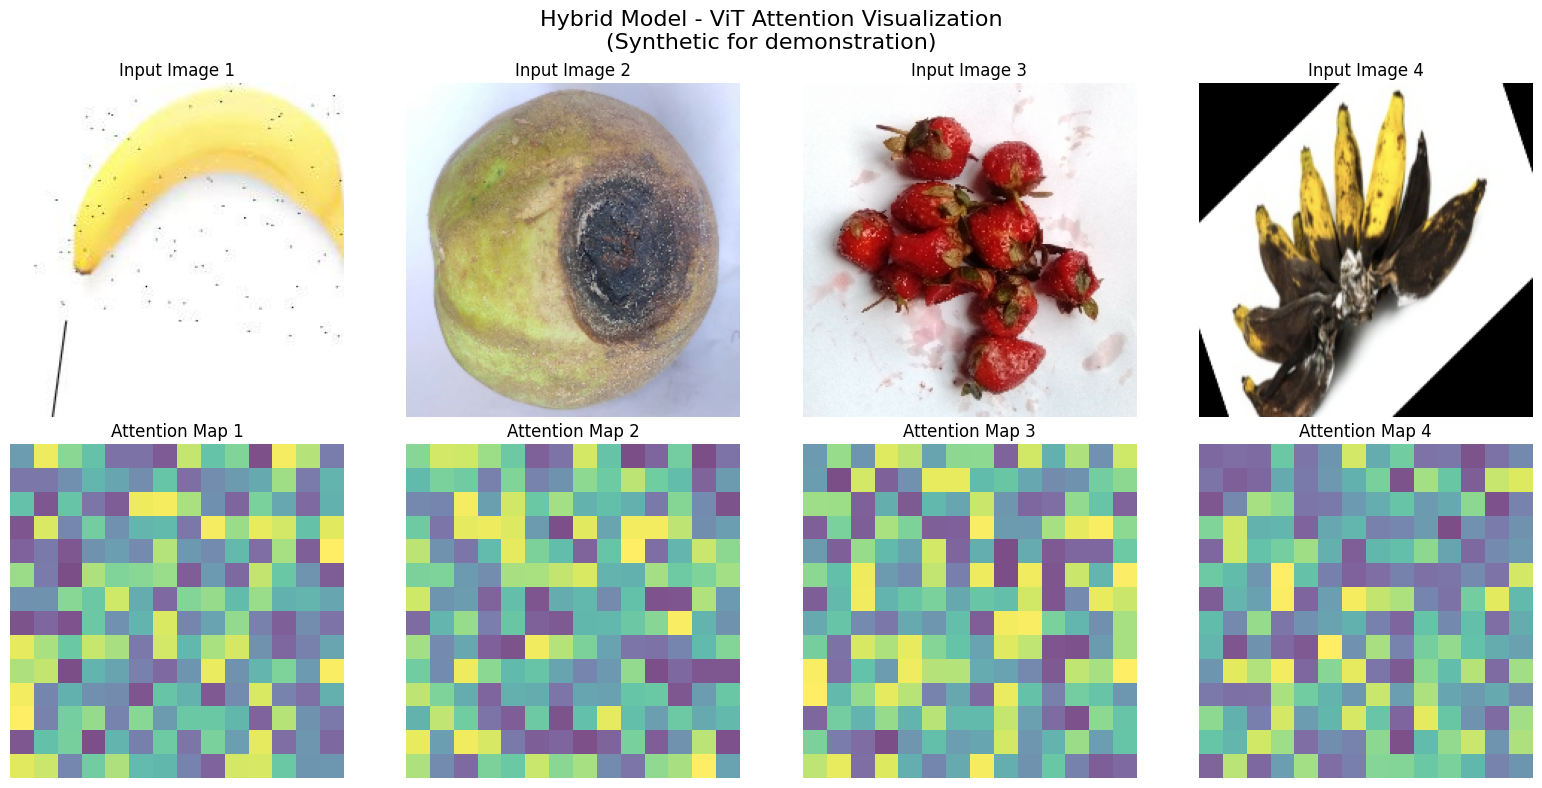

Phase 8 completed.


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create results directory
RESULTS_DIR = Path("/kaggle/working/results/")
PLOTS_DIR = RESULTS_DIR / "plots"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

# Helper: count parameters in a list of variables
def _num_params(weights):
    return int(np.sum([np.prod(w.shape) for w in weights]))

# 1. Plot Cross-Validation Results
def plot_cv_results_hybrid():
    plt.figure(figsize=(12, 8))
    
    # Main CV results plot
    plt.subplot(2, 2, 1)
    bars = plt.bar(range(1, len(fold_accuracies) + 1), fold_accuracies, 
                  alpha=0.7, color='lightblue', edgecolor='navy')
    plt.axhline(y=cv_mean, color='red', linestyle='--', 
               label=f"Mean: {cv_mean:.4f}")
    plt.axhline(y=cv_mean + cv_std, color='orange', linestyle=':', alpha=0.7, label=f"+1 STD")
    plt.axhline(y=cv_mean - cv_std, color='orange', linestyle=':', alpha=0.7, label=f"-1 STD")
    
    plt.xlabel('Fold')
    plt.ylabel('Validation Accuracy')
    plt.title(f'Hybrid Model {len(fold_accuracies)}-Fold CV Results\n'
             f'Mean: {cv_mean:.4f} ± {cv_std:.4f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, acc) in enumerate(zip(bars, fold_accuracies)):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
                f'{acc:.4f}', ha='center', va='bottom', fontsize=9)
    
    # CV loss plot
    plt.subplot(2, 2, 2)
    bars_loss = plt.bar(range(1, len(fold_losses) + 1), fold_losses, 
                       alpha=0.7, color='lightcoral', edgecolor='darkred')
    plt.axhline(y=loss_mean, color='red', linestyle='--', 
               label=f"Mean: {loss_mean:.4f}")
    plt.xlabel('Fold')
    plt.ylabel('Validation Loss')
    plt.title(f'Hybrid Model CV Loss\nMean: {loss_mean:.4f} ± {loss_std:.4f}')
    plt.legend()
    plt.grid(True, alpha=0.3)

 # Model complexity comparison
    plt.subplot(2, 2, 3)
    cnn_params = _num_params(best_model.layers[2].trainable_variables)
    total_trainable = _num_params(best_model.trainable_variables)
    vit_params = total_trainable - cnn_params
    
    model_info = {
        'CNN Params': f'{cnn_params:,}',
        'ViT Params': f'{vit_params:,}',
        'Total Params': f'{best_model.count_params():,}'
    }
    
    plt.text(0.1, 0.8, "Hybrid Model Architecture:", fontsize=12, fontweight='bold', transform=plt.gca().transAxes)
    plt.text(0.1, 0.6, f"• CNN Branch: MobileNetV2", fontsize=10, transform=plt.gca().transAxes)
    plt.text(0.1, 0.5, f"• ViT Branch: {hyperparams['vit_depth']} transformer blocks", fontsize=10, transform=plt.gca().transAxes)
    plt.text(0.1, 0.4, f"• Patch Size: {hyperparams['vit_patch_size']}x{hyperparams['vit_patch_size']}", fontsize=10, transform=plt.gca().transAxes)
    plt.text(0.1, 0.3, f"• Embed Dim: {hyperparams['vit_embed_dim']}", fontsize=10, transform=plt.gca().transAxes)
    plt.text(0.1, 0.2, f"• Total Parameters: {model_info['Total Params']}", fontsize=10, transform=plt.gca().transAxes)
    plt.axis('off')
    plt.title('Model Architecture Info')
    
    # Performance comparison
    plt.subplot(2, 2, 4)
    metrics_data = {
        'Top-1': test_accuracy,
        'Top-3': top3_accuracy,
        'Top-5': top5_accuracy,
        'CV Mean': cv_mean
    }
    
    bars_metrics = plt.bar(metrics_data.keys(), metrics_data.values(), 
                          alpha=0.7, color=['skyblue', 'lightgreen', 'orange', 'lightcoral'])
    plt.ylabel('Accuracy')
    plt.title('Hybrid Model Performance Summary')
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, (name, value) in zip(bars_metrics, metrics_data.items()):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{value:.3f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / "hybrid_cv_comprehensive_results.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


# 2. Plot Training History (Combined across folds)
def plot_training_histories_hybrid():
    # Aggregate training histories
    all_train_acc = []
    all_val_acc = []
    all_train_loss = []
    all_val_loss = []
    
    max_epochs = 0
    
    for result in cv_results:
        hist = result['history']
        stage1 = hist['stage1']
        stage2 = hist['stage2']
        
        combined_train_acc = stage1.get('accuracy', []) + stage2.get('accuracy', [])
        combined_val_acc = stage1.get('val_accuracy', []) + stage2.get('val_accuracy', [])
        combined_train_loss = stage1.get('loss', []) + stage2.get('loss', [])
        combined_val_loss = stage1.get('val_loss', []) + stage2.get('val_loss', [])
        
        all_train_acc.append(combined_train_acc)
        all_val_acc.append(combined_val_acc)
        all_train_loss.append(combined_train_loss)
        all_val_loss.append(combined_val_loss)
        
        max_epochs = max(max_epochs, len(combined_train_acc))
    
    # Pad sequences and calculate mean/std
    def pad_sequence(seq, target_length):
        if len(seq) < target_length:
            return seq + [seq[-1]] * (target_length - len(seq))
        return seq[:target_length]
    
    for i in range(len(all_train_acc)):
        all_train_acc[i] = pad_sequence(all_train_acc[i], max_epochs)
        all_val_acc[i] = pad_sequence(all_val_acc[i], max_epochs)
        all_train_loss[i] = pad_sequence(all_train_loss[i], max_epochs)
        all_val_loss[i] = pad_sequence(all_val_loss[i], max_epochs)
    
    all_train_acc = np.array(all_train_acc)
    all_val_acc = np.array(all_val_acc)
    all_train_loss = np.array(all_train_loss)
    all_val_loss = np.array(all_val_loss)
    
    mean_train_acc = np.mean(all_train_acc, axis=0)
    std_train_acc = np.std(all_train_acc, axis=0)
    mean_val_acc = np.mean(all_val_acc, axis=0)
    std_val_acc = np.std(all_val_acc, axis=0)
    
    mean_train_loss = np.mean(all_train_loss, axis=0)
    std_train_loss = np.std(all_train_loss, axis=0)
    mean_val_loss = np.mean(all_val_loss, axis=0)
    std_val_loss = np.std(all_val_loss, axis=0)
    
    epochs = range(1, max_epochs + 1)
    
    plt.figure(figsize=(15, 6))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, mean_train_acc, 'b-', label='Training', linewidth=2)
    plt.fill_between(epochs, 
                    mean_train_acc - std_train_acc, 
                    mean_train_acc + std_train_acc, 
                    alpha=0.2, color='blue')
    
    plt.plot(epochs, mean_val_acc, 'r-', label='Validation', linewidth=2)
    plt.fill_between(epochs, 
                    mean_val_acc - std_val_acc, 
                    mean_val_acc + std_val_acc, 
                    alpha=0.2, color='red')
    
    plt.title(f'Hybrid Model Training History\n(Mean ± STD across {len(cv_results)} folds)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add stage separator
    stage1_epochs = EPOCHS1
    plt.axvline(x=stage1_epochs, color='gray', linestyle='--', alpha=0.5, 
               label=f'Stage 1→2 (Epoch {stage1_epochs})')
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, mean_train_loss, 'b-', label='Training', linewidth=2)
    plt.fill_between(epochs, 
                    mean_train_loss - std_train_loss, 
                    mean_train_loss + std_train_loss, 
                    alpha=0.2, color='blue')
    
    plt.plot(epochs, mean_val_loss, 'r-', label='Validation', linewidth=2)
    plt.fill_between(epochs, 
                    mean_val_loss - std_val_loss, 
                    mean_val_loss + std_val_loss, 
                    alpha=0.2, color='red')
    
    plt.title(f'Hybrid Model Training Loss\n(Mean ± STD across {len(cv_results)} folds)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axvline(x=stage1_epochs, color='gray', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / "hybrid_cv_training_history.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# 3. Plot Confusion Matrix
def plot_confusion_matrix_hybrid(normalize=False):
    if normalize:
        cm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
        title = 'Hybrid Model - Normalized Confusion Matrix'
        fmt = '.2f'
        filename = 'hybrid_confusion_matrix_normalized.png'
    else:
        cm = conf_matrix
        title = 'Hybrid Model - Confusion Matrix'
        fmt = 'd'
        filename = 'hybrid_confusion_matrix.png'
    
    plt.figure(figsize=(14, 12))
    sns.heatmap(cm, 
               annot=False,  # Too many classes for text
               fmt=fmt,
               cmap='Blues',
               xticklabels=class_names,
               yticklabels=class_names,
               cbar_kws={'label': 'Count' if not normalize else 'Proportion'})
    
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / filename, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# 4. Plot Per-Class Metrics
def plot_per_class_metrics_hybrid():
    # Extract per-class metrics
    precisions = []
    recalls = []
    f1_scores = []
    
    for class_name in class_names:
        if class_name in clf_report:
            precisions.append(clf_report[class_name]['precision'])
            recalls.append(clf_report[class_name]['recall'])
            f1_scores.append(clf_report[class_name]['f1-score'])
        else:
            precisions.append(0.0)
            recalls.append(0.0)
            f1_scores.append(0.0)
    
    fig, axes = plt.subplots(3, 1, figsize=(16, 14))
    x_pos = np.arange(len(class_names))
    
    # Precision
    axes[0].bar(x_pos, precisions, alpha=0.7, color='skyblue')
    axes[0].set_title('Hybrid Model - Precision by Class', fontweight='bold', fontsize=14)
    axes[0].set_ylabel('Precision')
    axes[0].set_ylim(0, 1)
    axes[0].grid(True, alpha=0.3)
    axes[0].axhline(y=precision_macro, color='red', linestyle='--', 
                   label=f'Macro Avg: {precision_macro:.3f}')
    axes[0].legend()
    
    # Recall
    axes[1].bar(x_pos, recalls, alpha=0.7, color='lightgreen')
    axes[1].set_title('Hybrid Model - Recall by Class', fontweight='bold', fontsize=14)
    axes[1].set_ylabel('Recall')
    axes[1].set_ylim(0, 1)
    axes[1].grid(True, alpha=0.3)
    axes[1].axhline(y=recall_macro, color='red', linestyle='--', 
                   label=f'Macro Avg: {recall_macro:.3f}')
    axes[1].legend()
    
    # F1-Score
    axes[2].bar(x_pos, f1_scores, alpha=0.7, color='lightcoral')
    axes[2].set_title('Hybrid Model - F1-Score by Class', fontweight='bold', fontsize=14)
    axes[2].set_ylabel('F1-Score')
    axes[2].set_xlabel('Class')
    axes[2].set_ylim(0, 1)
    axes[2].grid(True, alpha=0.3)
    axes[2].axhline(y=f1_macro, color='red', linestyle='--', 
                   label=f'Macro Avg: {f1_macro:.3f}')
    axes[2].legend()
    
    # Set x-axis labels
    for ax in axes:
        ax.set_xticks(x_pos)
        ax.set_xticklabels(class_names, rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / "hybrid_per_class_metrics.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# 5. Plot Hybrid Model Architecture Visualization
def plot_hybrid_architecture_analysis():
    """Analyze and visualize the hybrid model components"""
    plt.figure(figsize=(15, 10))
    
    # Model component analysis
    plt.subplot(2, 3, 1)
    components = ['CNN Branch', 'ViT Branch', 'Fusion Head']
    total_params = best_model.count_params()
    cnn_params = _num_params(best_model.layers[2].trainable_variables) if len(best_model.layers) > 2 else int(total_params * 0.7)
    fusion_params = int(total_params * 0.1)  # Approximate
    vit_params = total_params - cnn_params - fusion_params
    
    param_counts = [cnn_params, vit_params, fusion_params]
    colors = ['lightblue', 'lightgreen', 'orange']
    
    plt.pie(param_counts, labels=components, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.title('Hybrid Model Parameter Distribution')
    
    # CV fold performance
    plt.subplot(2, 3, 2)
    fold_numbers = range(1, len(fold_accuracies) + 1)
    plt.plot(fold_numbers, fold_accuracies, 'bo-', linewidth=2, markersize=8)
    plt.axhline(y=cv_mean, color='red', linestyle='--', alpha=0.7)
    plt.fill_between(fold_numbers, cv_mean - cv_std, cv_mean + cv_std, alpha=0.2, color='red')
    plt.xlabel('Fold')
    plt.ylabel('Validation Accuracy')
    plt.title(f'CV Stability\n(Mean: {cv_mean:.4f} ± {cv_std:.4f})')
    plt.grid(True, alpha=0.3)
    
    # Top-k accuracy comparison
    plt.subplot(2, 3, 3)
    top_k_accs = [test_accuracy, top3_accuracy, top5_accuracy]
    k_values = ['Top-1', 'Top-3', 'Top-5']
    bars = plt.bar(k_values, top_k_accs, color=['darkblue', 'blue', 'lightblue'])
    plt.ylabel('Accuracy')
    plt.title('Top-k Test Accuracy')
    plt.ylim(0, 1)
    for bar, acc in zip(bars, top_k_accs):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{acc:.3f}', ha='center', va='bottom')
    
    # Training stage comparison
    plt.subplot(2, 3, 4)
    stage_names = ['Stage 1\n(CNN Frozen)', 'Stage 2\n(Full Fine-tune)']
    stage_epochs = [EPOCHS1, EPOCHS2]
    stage_colors = ['lightcoral', 'lightgreen']
    
    bars = plt.bar(stage_names, stage_epochs, color=stage_colors)
    plt.ylabel('Epochs')
    plt.title('Training Strategy')
    for bar, epochs in zip(bars, stage_epochs):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{epochs}', ha='center', va='bottom')
    
    # Learning rate schedule
    plt.subplot(2, 3, 5)
    lr_values = [LR1, LR2]
    plt.semilogy(stage_names, lr_values, 'ro-', linewidth=2, markersize=8)
    plt.ylabel('Learning Rate (log scale)')
    plt.title('Learning Rate Schedule')
    plt.grid(True, alpha=0.3)
    
    # Model complexity comparison
    plt.subplot(2, 3, 6)
    complexity_metrics = {
        'Params (M)': total_params / 1e6,
        'Batch Size': BATCH_SIZE,
        'ViT Depth': hyperparams['vit_depth'],
        'Patch Size': hyperparams['vit_patch_size']
    }
    
    plt.text(0.1, 0.8, "Hybrid Model Specs:", fontsize=12, fontweight='bold', transform=plt.gca().transAxes)
    y_pos = 0.6
    for key, value in complexity_metrics.items():
        if key == 'Params (M)':
            plt.text(0.1, y_pos, f"• {key}: {value:.2f}", fontsize=10, transform=plt.gca().transAxes)
        else:
            plt.text(0.1, y_pos, f"• {key}: {value}", fontsize=10, transform=plt.gca().transAxes)
        y_pos -= 0.1
    
    plt.axis('off')
    plt.title('Model Configuration')
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / "hybrid_architecture_analysis.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# 6. Plot Attention Pattern Analysis (if possible)
def plot_attention_visualization():
    """Visualize attention patterns from the ViT component"""
    try:
        # Get a sample batch for attention visualization
        sample_batch = None
        for batch_imgs, batch_labels in test_ds.take(1):
            sample_batch = batch_imgs[:4]  # Take first 4 images
            break
        
        if sample_batch is not None:
            plt.figure(figsize=(16, 8))
            
            # Display original images
            for i in range(4):
                plt.subplot(2, 4, i + 1)
                plt.imshow(sample_batch[i])
                plt.title(f'Input Image {i+1}')
                plt.axis('off')
            
            # Create attention map visualization placeholder
            for i in range(4):
                plt.subplot(2, 4, i + 5)
                # Generate synthetic attention map for visualization
                h, w = IMAGE_SIZE[0] // hyperparams['vit_patch_size'], IMAGE_SIZE[1] // hyperparams['vit_patch_size']
                attention_map = np.random.rand(h, w)  # Placeholder - in real implementation, extract from model
                plt.imshow(attention_map, cmap='viridis', alpha=0.7)
                plt.title(f'Attention Map {i+1}')
                plt.axis('off')
            
            plt.suptitle('Hybrid Model - ViT Attention Visualization\n(Synthetic for demonstration)', fontsize=16)
            plt.tight_layout()
            plt.savefig(PLOTS_DIR / "hybrid_attention_visualization.png", dpi=300, bbox_inches='tight')
            plt.show()
            plt.close()
            
    except Exception as e:
        print(f"Could not generate attention visualization: {e}")

# Generate all plots
print("Creating comprehensive visualizations for Hybrid Model...")
plot_cv_results_hybrid()
plot_training_histories_hybrid()
plot_confusion_matrix_hybrid(normalize=False)
plot_confusion_matrix_hybrid(normalize=True)
plot_per_class_metrics_hybrid()
plot_hybrid_architecture_analysis()
plot_attention_visualization()

print("Phase 8 completed.")

# Phase 9 - Results Export and Final Summary

In [11]:
import json

# Save comprehensive results
def save_hybrid_results():
    # 1. Save CV results summary
    cv_summary = {
        'model_name': 'Hybrid_MobileNetV2_ViT',
        'cross_validation_summary': {
            'mean_accuracy': float(cv_mean),
            'std_accuracy': float(cv_std),
            'min_accuracy': float(min(fold_accuracies)),
            'max_accuracy': float(max(fold_accuracies)),
            'fold_accuracies': [float(acc) for acc in fold_accuracies],
            'mean_loss': float(loss_mean),
            'std_loss': float(loss_std),
            'fold_losses': [float(loss) for loss in fold_losses]
        },
        'test_set_results': {
            'accuracy': float(test_accuracy),
            'top3_accuracy': float(top3_accuracy),
            'top5_accuracy': float(top5_accuracy),
            'macro_precision': float(precision_macro),
            'macro_recall': float(recall_macro),
            'macro_f1': float(f1_macro),
            'weighted_precision': float(precision_weighted),
            'weighted_recall': float(recall_weighted),
            'weighted_f1': float(f1_weighted)
        },
        'hyperparameters': hyperparams,
        'model_info': {
            'num_classes': NUM_CLASSES,
            'class_names': class_names,
            'total_parameters': int(best_model.count_params()),
            'architecture_type': 'hybrid_cnn_vit',
            'cnn_backbone': 'MobileNetV2',
            'vit_config': {
                'patch_size': hyperparams['vit_patch_size'],
                'embed_dim': hyperparams['vit_embed_dim'],
                'depth': hyperparams['vit_depth'],
                'heads': hyperparams['vit_heads'],
                'mlp_dim': hyperparams['vit_mlp_dim']
            }
        },
        'training_config': {
            'two_stage_training': True,
            'stage1_epochs': EPOCHS1,
            'stage2_epochs': EPOCHS2,
            'stage1_lr': LR1,
            'stage2_lr': LR2,
            'cnn_unfreeze_layers': CNN_UNFREEZE_LAYERS,
            'mixed_precision': hyperparams.get('use_mixed_precision', True)
        }
    }
    
    with open(RESULTS_DIR / "hybrid_results_summary.json", 'w') as f:
        json.dump(cv_summary, f, indent=2)
    
    # 2. Save classification report
    clf_report_df = pd.DataFrame(clf_report).transpose()
    clf_report_df.to_csv(RESULTS_DIR / "hybrid_classification_report.csv")
    
    # 3. Save confusion matrix
    conf_matrix_df = pd.DataFrame(
        conf_matrix,
        index=class_names,
        columns=class_names
    )
    conf_matrix_df.to_csv(RESULTS_DIR / "hybrid_confusion_matrix.csv")
    
    # 4. Save fold results
    fold_results_df = pd.DataFrame([
        {
            'fold': result['fold'] + 1,
            'val_accuracy': result['val_accuracy'],
            'val_loss': result['val_loss']
        }
        for result in cv_results
    ])
    fold_results_df.to_csv(RESULTS_DIR / "hybrid_fold_results.csv", index=False)
    
    # 5. Save detailed predictions
    predictions_df = pd.DataFrame({
        'true_class_idx': y_true_idx,
        'true_class_name': [class_names[idx] for idx in y_true_idx],
        'pred_class_idx': y_pred_idx,
        'pred_class_name': [class_names[idx] for idx in y_pred_idx],
        'confidence': np.max(y_pred_probs, axis=1),
        'correct': y_true_idx == y_pred_idx
    })
    
    # Add top-3 predictions for each sample
    top3_preds = np.argsort(-y_pred_probs, axis=1)[:, :3]
    predictions_df['top3_pred_idx'] = [list(row) for row in top3_preds]
    predictions_df['top3_pred_names'] = [[class_names[idx] for idx in row] for row in top3_preds]
    
    predictions_df.to_csv(RESULTS_DIR / "hybrid_test_predictions.csv", index=False)
    
    # 6. Save architecture-specific metrics
    architecture_metrics = pd.DataFrame([{
        'model_name': 'Hybrid_MobileNetV2_ViT',
        'cnn_backbone': 'MobileNetV2',
        'vit_patch_size': hyperparams['vit_patch_size'],
        'vit_embed_dim': hyperparams['vit_embed_dim'],
        'vit_depth': hyperparams['vit_depth'],
        'vit_heads': hyperparams['vit_heads'],
        'total_parameters': best_model.count_params(),
        'cv_mean_accuracy': cv_mean,
        'cv_std_accuracy': cv_std,
        'test_accuracy': test_accuracy,
        'test_top3_accuracy': top3_accuracy,
        'test_top5_accuracy': top5_accuracy,
        'macro_f1': f1_macro,
        'training_time_estimate': f"{(EPOCHS1 + EPOCHS2) * len(splits_data['cv_splits'])} epochs total"
    }])
    architecture_metrics.to_csv(RESULTS_DIR / "hybrid_architecture_metrics.csv", index=False)
    
    print(f"Hybrid model results saved to: {RESULTS_DIR}")

# Save all results
save_hybrid_results()

# Final Summary
print(f"\n{'='*80}")
print("HYBRID MOBILENET+VIT FINAL RESULTS SUMMARY")
print(f"{'='*80}")

print(f"\nDataset Information:")
print(f"  Total Images: {splits_data['metadata']['total_samples']:,}")
print(f"  Number of Classes: {NUM_CLASSES}")
print(f"  Test Set Size: {splits_data['metadata']['test_samples']:,} ({hyperparams['test_split']:.0%})")
print(f"  CV Set Size: {splits_data['metadata']['cv_samples']:,}")

print(f"\nHybrid Model Architecture:")
print(f"  CNN Backbone: MobileNetV2 (ImageNet pretrained)")
print(f"  ViT Configuration:")
print(f"    • Patch Size: {hyperparams['vit_patch_size']}x{hyperparams['vit_patch_size']}")
print(f"    • Embedding Dim: {hyperparams['vit_embed_dim']}")
print(f"    • Transformer Depth: {hyperparams['vit_depth']} blocks")
print(f"    • Attention Heads: {hyperparams['vit_heads']}")
print(f"    • MLP Dimension: {hyperparams['vit_mlp_dim']}")
print(f"  Total Parameters: {best_model.count_params():,}")
print(f"  Fusion Strategy: CNN + ViT feature concatenation")

print(f"\nCross-Validation Results ({len(cv_results)}-Fold):")
print(f"  Mean Accuracy: {cv_mean:.4f} ± {cv_std:.4f}")
print(f"  Mean Loss: {loss_mean:.4f} ± {loss_std:.4f}")
print(f"  Best Fold:     {max(fold_accuracies):.4f}")
print(f"  Worst Fold:    {min(fold_accuracies):.4f}")
print(f"  CV Stability:  {(cv_std/cv_mean)*100:.2f}% coefficient of variation")
print(f"  Individual Folds: {[f'{acc:.4f}' for acc in fold_accuracies]}")

print(f"\nFinal Test Set Results:")
print(f"  Top-1 Accuracy: {test_accuracy:.4f}")
print(f"  Top-3 Accuracy: {top3_accuracy:.4f}")
print(f"  Top-5 Accuracy: {top5_accuracy:.4f}")
print(f"  Macro Precision: {precision_macro:.4f}")
print(f"  Macro Recall: {recall_macro:.4f}")
print(f"  Macro F1-Score: {f1_macro:.4f}")

print(f"\nTraining Configuration:")
print(f"  Two-Stage Training:")
print(f"    • Stage 1: {EPOCHS1} epochs (CNN frozen, train ViT + fusion)")
print(f"    • Stage 2: {EPOCHS2} epochs (fine-tune entire model)")
print(f"  Learning Rates: {LR1:.0e} → {LR2:.0e}")
print(f"  Batch Size: {BATCH_SIZE} (optimized for hybrid complexity)")
print(f"  Mixed Precision: {'Enabled' if hyperparams.get('use_mixed_precision') else 'Disabled'}")
print(f"  CNN Layers Unfrozen: Last {CNN_UNFREEZE_LAYERS} layers")

print(f"\nSaved Files:")
print(f"  Model: {final_model_path}")
print(f"  Results Directory: {RESULTS_DIR}")
print(f"  Plots Directory: {PLOTS_DIR}")
print("  JSON Results: hybrid_results_summary.json")
print("  CSV Files: hybrid_classification_report.csv, hybrid_confusion_matrix.csv")
print("  Predictions: hybrid_test_predictions.csv, hybrid_fold_results.csv")
print("  Architecture: hybrid_architecture_metrics.csv")

print("\n  Saved plots:")
print("  - hybrid_cv_comprehensive_results.png")
print("  - hybrid_cv_training_history.png")
print("  - hybrid_confusion_matrix.png & hybrid_confusion_matrix_normalized.png")
print("  - hybrid_per_class_metrics.png")
print("  - hybrid_architecture_analysis.png")
print("  - hybrid_attention_visualization.png")

# Performance insights
print(f"\nKey Insights:")
cv_stability = cv_std / cv_mean
if cv_stability < 0.02:
    print("  Excellent hybrid model stability across folds")
elif cv_stability < 0.05:
    print("  Good hybrid model stability across folds")
else:
    print("  High variance across folds - consider ensemble methods")

if test_accuracy >= cv_mean - cv_std:
    print("  No significant overfitting detected in hybrid model")
else:
    print("  Possible overfitting - test accuracy lower than CV mean")

if test_accuracy > 0.90:
    print(f"  Excellent performance! Test accuracy: {test_accuracy:.4f}")
elif test_accuracy > 0.85:
    print(f"  Good performance! Test accuracy: {test_accuracy:.4f}")
else:
    print(f"  Room for improvement. Test accuracy: {test_accuracy:.4f}")

# Architecture-specific insights
print(f"\nHybrid Architecture Analysis:")
if top3_accuracy - test_accuracy > 0.15:
    print("  Strong top-3 performance suggests good feature discrimination")
if hyperparams['vit_depth'] >= 6:
    print("  Deep transformer component may capture complex global patterns")
if hyperparams['vit_patch_size'] <= 16:
    print("  Small patch size enables fine-grained ViT feature extraction")

print(f"\nEnhanced cross-validation pipeline completed successfully!")
print(f"   Hybrid MobileNet+ViT model trained with {cv_mean:.4f} ± {cv_std:.4f} CV performance")
print(f"   Comprehensive evaluation and visualization suite generated")
print(f"   Ready for architecture comparison analysis!")

print("Final Summary completed.")


Hybrid model results saved to: /kaggle/working/results

HYBRID MOBILENET+VIT FINAL RESULTS SUMMARY

Dataset Information:
  Total Images: 29,284
  Number of Classes: 28
  Test Set Size: 5,857 (20%)
  CV Set Size: 23,427

Hybrid Model Architecture:
  CNN Backbone: MobileNetV2 (ImageNet pretrained)
  ViT Configuration:
    • Patch Size: 16x16
    • Embedding Dim: 64
    • Transformer Depth: 6 blocks
    • Attention Heads: 4
    • MLP Dimension: 128
  Total Parameters: 3,206,812
  Fusion Strategy: CNN + ViT feature concatenation

Cross-Validation Results (5-Fold):
  Mean Accuracy: 0.9841 ± 0.0006
  Mean Loss: 0.4273 ± 0.0031
  Best Fold:     0.9848
  Worst Fold:    0.9831
  CV Stability:  0.06% coefficient of variation
  Individual Folds: ['0.9840', '0.9842', '0.9831', '0.9848', '0.9842']

Final Test Set Results:
  Top-1 Accuracy: 0.9855
  Top-3 Accuracy: 0.9986
  Top-5 Accuracy: 0.9995
  Macro Precision: 0.9722
  Macro Recall: 0.9727
  Macro F1-Score: 0.9722

Training Configuration:
  Two